# *Skin Cancer Detection with Custom CNN and Pretrained Models on HAM10000 Dataset*

*Importing Required Libraries for Deep Learning Project*

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import math
import pandas as pd
import seaborn as sns
import os
import itertools
from glob import glob
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import keras
from keras import backend
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, model_from_json, Model, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, Callback, CSVLogger
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import InceptionV3, ResNet152V2, VGG16

# To see the value of multiple statements at once.
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

*Custom Keras Callback for Tracking Epoch Time*

In [2]:
import time

class TimeHistory(Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

*Custom RMSE Metric Function*

In [3]:
def rmse(y_true, y_pred):
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

*Function to Add Custom CNN Layers on Top of Base Model*

In [4]:
def add_cnn_layers(base_model, model):
    model.add(base_model)
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.40))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(7, activation='softmax'))
    model.summary()
    return model

*Function to Evaluate and Print Detailed Train and Validation Metrics*

In [5]:
def train_val_accuracy_detailed(model, x_train_normalized, x_val_normalized, y_train, y_val):
    import tensorflow as tf

    # Compile the model (if not already compiled)
    if not model._is_compiled:  # `_is_compiled` checks if the model is compiled
        print("Model is not compiled. Compiling now...")
        model.compile(
            optimizer='adam',  # Adjust optimizer as needed
            loss='categorical_crossentropy',  # Adjust loss function as needed
            metrics=['accuracy', 'mse', 'mape', tf.keras.metrics.RootMeanSquaredError()]  # Additional metrics
        )
        print("Model compiled successfully.")

    # Check available devices
    print("Available devices:", tf.config.list_physical_devices('GPU'))

    try:
        with tf.device('/GPU:0'):  # Force computation on GPU
            # Evaluate on training data
            train_results = model.evaluate(x_train_normalized, y_train, verbose=1)
            val_results = model.evaluate(x_val_normalized, y_val, verbose=1)
    except Exception as e:
        print("Error during GPU execution:", e)
        print("Falling back to CPU...")
        with tf.device('/CPU:0'):  # Fallback to CPU if GPU fails
            train_results = model.evaluate(x_train_normalized, y_train, verbose=1)
            val_results = model.evaluate(x_val_normalized, y_val, verbose=1)

    # Extract relevant metrics
    train_loss = train_results[0]  # First value is always loss
    train_accuracy = train_results[1]
    train_mse = train_results[2]
    train_mape = train_results[3]
    train_rmse = train_results[4]

    val_loss = val_results[0]
    val_accuracy = val_results[1]
    val_mse = val_results[2]
    val_mape = val_results[3]
    val_rmse = val_results[4]

    # Print all metrics
    print(f"Train Loss: {train_loss}")
    print(f"Train Accuracy: {train_accuracy * 100:.2f}%")
    print(f"Train RMSE: {train_rmse}")
    print(f"Train MSE: {train_mse}")
    print(f"Train MAPE: {train_mape}\n")

    print(f"Validation Loss: {val_loss}")
    print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")
    print(f"Validation RMSE: {val_rmse}")
    print(f"Validation MSE: {val_mse}")
    print(f"Validation MAPE: {val_mape}\n")

*Function to Evaluate Model Accuracy on Test Set*

In [6]:
import tensorflow as tf

def test_accuracy(model, x_test_normalized, y_test):
    """
    Evaluates the model on the test set, using GPU if available, otherwise falls back to CPU.
    
    Parameters:
    - model: Trained model to evaluate.
    - x_test_normalized: Normalized test features.
    - y_test: True test labels.
    """
    try:
        # Check for GPU and use it if available
        if tf.config.list_physical_devices('GPU'):
            print("GPU detected. Using GPU for evaluation.")
            with tf.device('/GPU:0'):
                test_loss, test_accuracy, test_mse, test_mape, test_rmse = model.evaluate(x_test_normalized, y_test, verbose=1)
        else:
            raise RuntimeError("No GPU found, switching to CPU.")
    except Exception as e:
        print(f"Error: {e}. Switching to CPU.")
        with tf.device('/CPU:0'):
            test_loss, test_accuracy, test_mse, test_mape, test_rmse = model.evaluate(x_test_normalized, y_test, verbose=1)

    # Print evaluation results
    print("\nTest Set Accuracy: ", test_accuracy * 100, "%",
          "\nTest Set Loss:", test_loss,
          "\nTest Set RMSE:", test_rmse,
          "\nTest Set MSE:", test_mse,
          "\nTest Set MAPE:", test_mape)


*Function to Plot Training History of the Model*

In [7]:
import matplotlib.pyplot as plt
import numpy as np

def plot_model_history(model_history, name):
    fig, axs = plt.subplots(2, 2, figsize=(15, 15))
    
    # Define number of epochs
    epochs = range(1, len(model_history.history['accuracy']) + 1)

    # Summarize history for accuracy
    axs[0, 0].plot(epochs, model_history.history['accuracy'])
    axs[0, 0].plot(epochs, model_history.history['val_accuracy'])
    axs[0, 0].set_title('Model Accuracy')
    axs[0, 0].set_ylabel('Accuracy')
    axs[0, 0].set_xlabel('Epoch')
    axs[0, 0].set_xticks(np.arange(1, len(model_history.history['accuracy']) + 1, step=max(1, len(epochs) // 10)))  # Set appropriate ticks
    axs[0, 0].legend(['Train', 'Validation'], loc='best')
    
    # Summarize history for loss
    axs[0, 1].plot(epochs, model_history.history['loss'])
    axs[0, 1].plot(epochs, model_history.history['val_loss'])
    axs[0, 1].set_title('Model Loss')
    axs[0, 1].set_ylabel('Loss')
    axs[0, 1].set_xlabel('Epoch')
    axs[0, 1].set_xticks(np.arange(1, len(model_history.history['loss']) + 1, step=max(1, len(epochs) // 10)))  # Set appropriate ticks
    axs[0, 1].legend(['Train', 'Validation'], loc='best')
    
    # Summarize history for RMSE
    if 'rmse' in model_history.history and 'val_rmse' in model_history.history:
        axs[1, 0].plot(epochs, model_history.history['rmse'])
        axs[1, 0].plot(epochs, model_history.history['val_rmse'])
        axs[1, 0].set_title('Model RMSE')
        axs[1, 0].set_ylabel('RMSE')
        axs[1, 0].set_xlabel('Epoch')
        axs[1, 0].set_xticks(np.arange(1, len(model_history.history['rmse']) + 1, step=max(1, len(epochs) // 10)))
        axs[1, 0].legend(['Train', 'Validation'], loc='best')
    else:
        axs[1, 0].text(0.5, 0.5, 'RMSE not available', fontsize=12, ha='center')
        axs[1, 0].set_title('Model RMSE')
    
    # Summarize history for MSE
    if 'mse' in model_history.history and 'val_mse' in model_history.history:
        axs[1, 1].plot(epochs, model_history.history['mse'])
        axs[1, 1].plot(epochs, model_history.history['val_mse'])
        axs[1, 1].set_title('Model MSE')
        axs[1, 1].set_ylabel('MSE')
        axs[1, 1].set_xlabel('Epoch')
        axs[1, 1].set_xticks(np.arange(1, len(model_history.history['mse']) + 1, step=max(1, len(epochs) // 10)))
        axs[1, 1].legend(['Train', 'Validation'], loc='best')
    else:
        axs[1, 1].text(0.5, 0.5, 'MSE not available', fontsize=12, ha='center')
        axs[1, 1].set_title('Model MSE')

    # Adjust layout and show the figures
    plt.tight_layout()
    plt.show()


*Function to Calculate Predicted and True Classes*

In [8]:
def cal_true_pred_classes(model, x_test_normalized, y_test):
    # Predict the values from the testing set
    y_predict = model.predict(x_test_normalized)

    # Convert prediction classes to one hot vectors 
    y_predict_classes = np.argmax(y_predict, axis=1) 

    # Convert testing label observations to one hot vectors
    y_true_classes = np.argmax(y_test, axis=1) 
    
    return y_predict_classes, y_true_classes

*Functions to Create and Plot the Confusion Matrix*

In [9]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Function to create and display the confusion matrix
def create_confusion_matrix(model, x_test_normalized, y_test, cm_plot_labels, name):
    """
    Creates and displays a confusion matrix.
    Automatically detects and switches between GPU and CPU for predictions.
    """
    try:
        # Check for GPU and use it if available
        if tf.config.list_physical_devices('GPU'):
            print("GPU detected. Using GPU for predictions.")
            with tf.device('/GPU:0'):
                y_predict_classes, y_true_classes = cal_true_pred_classes(model, x_test_normalized, y_test)
        else:
            raise RuntimeError("No GPU found, switching to CPU.")
    except Exception as e:
        print(f"Error: {e}. Switching to CPU.")
        with tf.device('/CPU:0'):
            y_predict_classes, y_true_classes = cal_true_pred_classes(model, x_test_normalized, y_test)
    
    # Compute the confusion matrix
    confusion_matrix_computed = confusion_matrix(y_true_classes, y_predict_classes)

    # Plot the confusion matrix
    plot_confusion_matrix(confusion_matrix_computed, cm_plot_labels, name)

# Function to plot the confusion matrix
def plot_confusion_matrix(cm, classes, name, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    """
    This function plots the confusion matrix.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Labels')
    plt.xlabel('Predicted Labels')

    # Display the confusion matrix plot without saving it
    plt.show()

*Function to Generate and Print the Classification Report*

In [10]:
import tensorflow as tf
from sklearn.metrics import classification_report

def gen_classification_report(model, x_test_normalized, y_test, cm_plot_labels):
    """
    Generates and prints a classification report.
    Automatically uses GPU for computations if available, otherwise falls back to CPU.
    
    Parameters:
    - model: Trained model for prediction.
    - x_test_normalized: Normalized test set features.
    - y_test: True test set labels.
    - cm_plot_labels: List of label names for the classification report.
    """
    try:
        # Check for GPU and use it if available
        if tf.config.list_physical_devices('GPU'):
            print("GPU detected. Using GPU for predictions.")
            with tf.device('/GPU:0'):
                y_predict_classes, y_true_classes = cal_true_pred_classes(model, x_test_normalized, y_test)
        else:
            raise RuntimeError("No GPU found, switching to CPU.")
    except Exception as e:
        print(f"Error: {e}. Switching to CPU.")
        with tf.device('/CPU:0'):
            y_predict_classes, y_true_classes = cal_true_pred_classes(model, x_test_normalized, y_test)
    
    # Generate the classification report
    report = classification_report(y_true_classes, y_predict_classes, target_names=cm_plot_labels)
    print(report)


*Function to Plot Classification Accuracy for Each Label*

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import tensorflow as tf

def plot_label_classification_acc(model, x_test_normalized, y_test, cm_plot_labels, name):
    """
    Plots the classification accuracy for each label based on the confusion matrix.
    Automatically uses GPU for computations if available, otherwise falls back to CPU.
    
    Parameters:
    - model: Trained model for prediction.
    - x_test_normalized: Normalized test set features.
    - y_test: True test set labels.
    - cm_plot_labels: List of label names for the confusion matrix.
    - name: Title for the plot.
    """
    try:
        # Check for GPU and use it if available
        if tf.config.list_physical_devices('GPU'):
            print("GPU detected. Using GPU for predictions.")
            with tf.device('/GPU:0'):
                y_predict_classes, y_true_classes = cal_true_pred_classes(model, x_test_normalized, y_test)
        else:
            raise RuntimeError("No GPU found, switching to CPU.")
    except Exception as e:
        print(f"Error: {e}. Switching to CPU.")
        with tf.device('/CPU:0'):
            y_predict_classes, y_true_classes = cal_true_pred_classes(model, x_test_normalized, y_test)
    
    # Compute the confusion matrix
    confusion_matrix_computed = confusion_matrix(y_true_classes, y_predict_classes)

    # Calculate per-class accuracy from confusion matrix
    cm_prediction_error = (np.diag(confusion_matrix_computed) / np.sum(confusion_matrix_computed, axis=1)) * 100

    # Bar plot for classification accuracy
    plt.figure(figsize=(10, 6))
    plt.bar(np.arange(len(cm_plot_labels)), cm_prediction_error, color='skyblue', alpha=0.8)

    # Add labels, title, and ticks
    plt.title(f"Classification Accuracy by Label - {name}", fontsize=14)
    plt.xlabel('Labels', fontsize=12)
    plt.ylabel('Accuracy (%)', fontsize=12)
    plt.xticks(np.arange(len(cm_plot_labels)), cm_plot_labels, rotation=45, fontsize=10)
    plt.ylim(0, 100)  # Accuracy is percentage, so limit between 0 and 100

    # Display the plot
    plt.tight_layout()
    plt.show()

*Defining Class Labels for Confusion Matrix Plots*

In [12]:
# Define the labels of the class indices. These need to match the order shown above.
cm_plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'nv', 'mel', 'vasc']

In [13]:
# Define the base directory for the skin cancer images
base_skin_dir = 'Input_Data/skin-cancer-mnist-ham10000'

# Get all image paths with a '.jpg' extension within subdirectories
all_image_path = glob(os.path.join(base_skin_dir, '*', '*.jpg'))

In [14]:
# Create a dictionary mapping image IDs (filename without extension) to their file paths
imageid_path_dict = {
    os.path.splitext(os.path.basename(x))[0]: x
    for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))
}

In [15]:
# Dictionary mapping lesion type class labels to their full descriptions
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [16]:
# Read the CSV file containing the metadata for the skin cancer dataset
skin_df = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))

In [17]:
# Add the image path to the DataFrame by mapping image IDs from 'image_id' column
skin_df['path'] = skin_df['image_id'].map(imageid_path_dict.get)  # Image Local Path

# Add the full lesion type name to the DataFrame by mapping 'dx' column
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get)  # Full 'dx' name

# Add a unique numeric code for each lesion type ('dx') for model use
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes  # Unique code for each 'dx'

In [18]:
skin_df.head()

lesion_id      image_id   dx dx_type   age   sex localization  \
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp   
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp   
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp   
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp   
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear   

                                                path  \
0  Input_Data/skin-cancer-mnist-ham10000\HAM10000...   
1  Input_Data/skin-cancer-mnist-ham10000\HAM10000...   
2  Input_Data/skin-cancer-mnist-ham10000\HAM10000...   
3  Input_Data/skin-cancer-mnist-ham10000\HAM10000...   
4  Input_Data/skin-cancer-mnist-ham10000\HAM10000...   

                       cell_type  cell_type_idx  
0  Benign keratosis-like lesions              2  
1  Benign keratosis-like lesions              2  
2  Benign keratosis-like lesions              2  
3  Benign keratosis-like lesions              2  
4  Benign keratosis-like lesions              2

In [19]:
skin_df.describe(exclude=[np.number])

lesion_id      image_id     dx dx_type    sex localization  \
count         10015         10015  10015   10015  10015        10015   
unique         7470         10015      7       4      3           15   
top     HAM_0003789  ISIC_0027419     nv   histo   male         back   
freq              6             1   6705    5340   5406         2192   

                                                     path         cell_type  
count                                               10015             10015  
unique                                              10015                 7  
top     Input_Data/skin-cancer-mnist-ham10000\HAM10000...  Melanocytic nevi  
freq                                                    1              6705

In [20]:
skin_df.describe()

age  cell_type_idx
count  9958.000000   10015.000000
mean     51.863828       3.623964
std      16.968614       1.208859
min       0.000000       0.000000
25%      40.000000       4.000000
50%      50.000000       4.000000
75%      65.000000       4.000000
max      85.000000       6.000000

In [21]:
# Drop duplicates based on the 'lesion_id' column
skin_df = skin_df.drop_duplicates(subset='lesion_id')

# Display the updated DataFrame
skin_df


lesion_id      image_id     dx dx_type   age     sex localization  \
0      HAM_0000118  ISIC_0027419    bkl   histo  80.0    male        scalp   
2      HAM_0002730  ISIC_0026769    bkl   histo  80.0    male        scalp   
4      HAM_0001466  ISIC_0031633    bkl   histo  75.0    male          ear   
6      HAM_0002761  ISIC_0029176    bkl   histo  60.0    male         face   
8      HAM_0005132  ISIC_0025837    bkl   histo  70.0  female         back   
...            ...           ...    ...     ...   ...     ...          ...   
9994   HAM_0000193  ISIC_0030877  akiec   histo  60.0  female         face   
10001  HAM_0000020  ISIC_0031922  akiec   histo  60.0  female         face   
10004  HAM_0005579  ISIC_0029309  akiec   histo  80.0    male         face   
10008  HAM_0001576  ISIC_0033705  akiec   histo  60.0    male         face   
10010  HAM_0002867  ISIC_0033084  akiec   histo  40.0    male      abdomen   

                                                    path  \
0      Input_Data/skin-cancer-mnist-ham10000\HAM10000...   
2      Input_Data/skin-cancer-mnist-ham10000\HAM10000...   
4      Input_Data/skin-cancer-mnist-ham10000\HAM10000...   
6      Input_Data/skin-cancer-mnist-ham10000\HAM10000...   
8      Input_Data/skin-cancer-mnist-ham10000\HAM10000...   
...                                                  ...   
9994   Input_Data/skin-cancer-mnist-ham10000\HAM10000...   
10001  Input_Data/skin-cancer-mnist-ham10000\HAM10000...   
10004  Input_Data/skin-cancer-mnist-ham10000\HAM10000...   
10008  Input_Data/skin-cancer-mnist-ham10000\HAM10000...   
10010  Input_Data/skin-cancer-mnist-ham10000\HAM10000...   

                           cell_type  cell_type_idx  
0      Benign keratosis-like lesions              2  
2      Benign keratosis-like lesions              2  
4      Benign keratosis-like lesions              2  
6      Benign keratosis-like lesions              2  
8      Benign keratosis-like lesions              2  
...                              ...            ...  
9994               Actinic keratoses              0  
10001              Actinic keratoses              0  
10004              Actinic keratoses              0  
10008              Actinic keratoses              0  
10010              Actinic keratoses              0  

[7470 rows x 10 columns]

In [22]:
skin_df.isnull().sum()

lesion_id         0
image_id          0
dx                0
dx_type           0
age              52
sex               0
localization      0
path              0
cell_type         0
cell_type_idx     0
dtype: int64

In [23]:
skin_df['age'].fillna(skin_df['age'].mean(), inplace=True)

In [24]:
skin_df.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age              0
sex              0
localization     0
path             0
cell_type        0
cell_type_idx    0
dtype: int64

<Figure size 1200x400 with 0 Axes>

<Axes: xlabel='cell_type'>

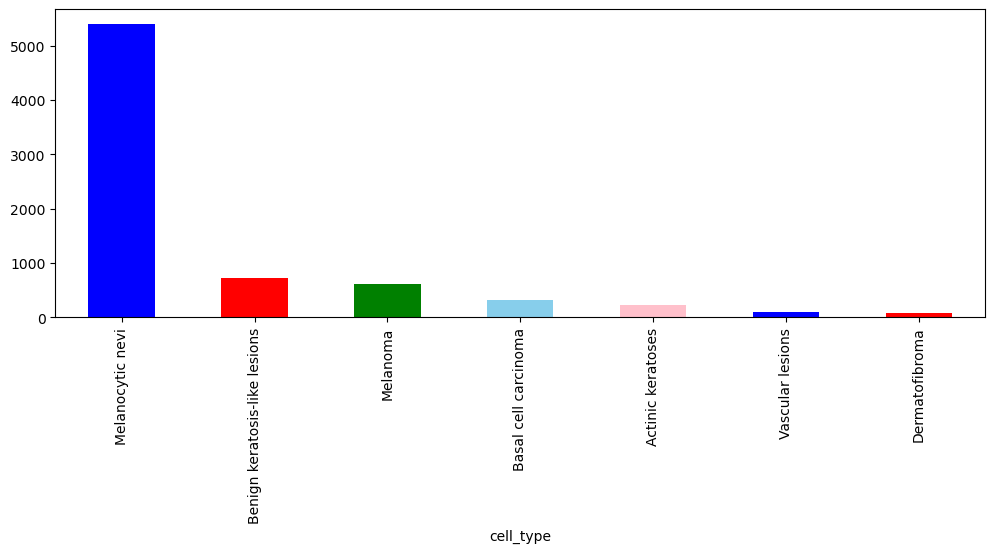

In [25]:
plt.figure(figsize=(12, 4))
skin_df['cell_type'].value_counts().plot(kind='bar', color=["blue", "red", "green", "skyblue", "pink"])

In [26]:
skin_df['cell_type'].value_counts()
skin_df['dx'].value_counts()

cell_type
Melanocytic nevi                 5403
Benign keratosis-like lesions     727
Melanoma                          614
Basal cell carcinoma              327
Actinic keratoses                 228
Vascular lesions                   98
Dermatofibroma                     73
Name: count, dtype: int64

dx
nv       5403
bkl       727
mel       614
bcc       327
akiec     228
vasc       98
df         73
Name: count, dtype: int64

<Figure size 1200x400 with 0 Axes>

<Axes: xlabel='dx'>

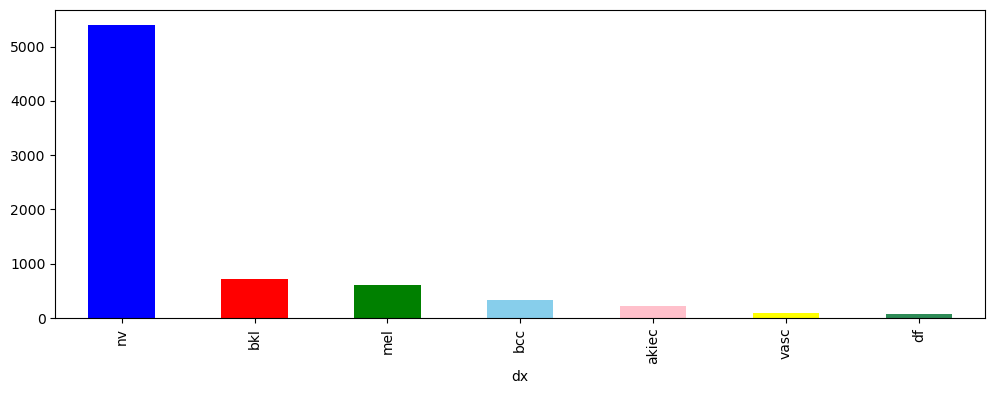

In [27]:
plt.figure(figsize=(12, 4))
skin_df['dx'].value_counts().plot(kind='bar', color=["blue", "red", "green", "skyblue", "pink", "yellow", "seagreen"])

<Figure size 1200x400 with 0 Axes>

<Axes: xlabel='localization'>

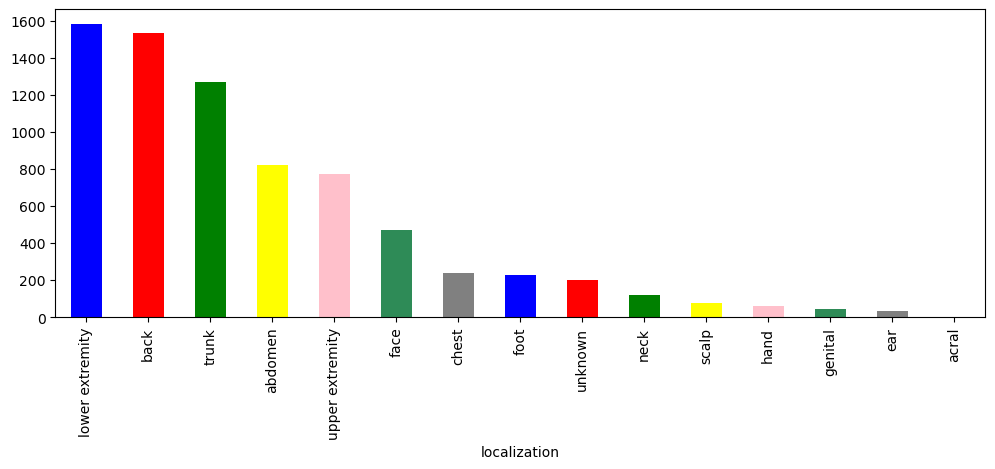

In [28]:
plt.figure(figsize=(12, 4))
skin_df['localization'].value_counts().plot(kind='bar', color=["blue", "red", "green", "yellow", "pink", "seagreen", "gray"])

<Axes: >

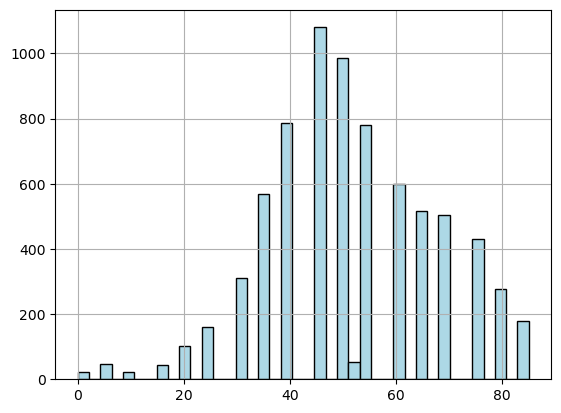

In [29]:
skin_df['age'].hist(bins=40, color='lightblue', edgecolor='black')

<Figure size 1200x400 with 0 Axes>

<Axes: xlabel='sex'>

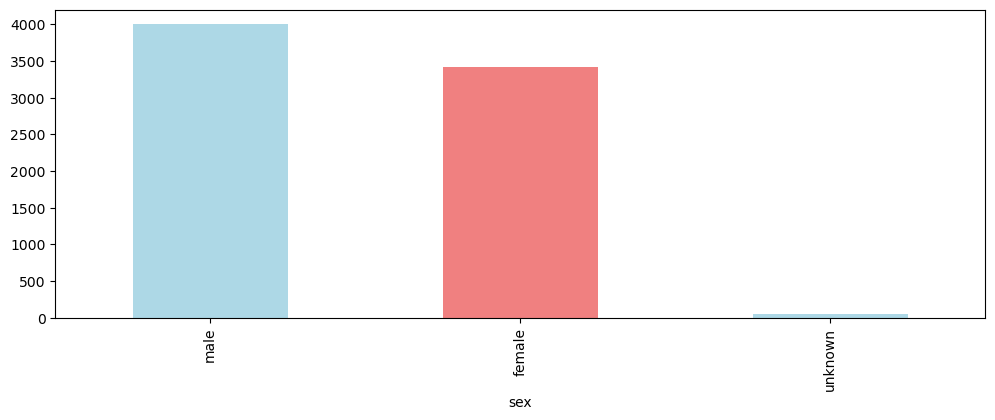

In [30]:
plt.figure(figsize=(12, 4))
skin_df['sex'].value_counts().plot(kind='bar', color=["lightblue", "lightcoral"])

In [31]:
im = Image.open(skin_df["path"].iloc[0])
width, height = im.size
print("Width: ", width)
print("Height:", height)

Width:  600
Height: 450


In [32]:
width /= 4
height /= 4
print("Width: ", width)
print("Height:", height)

Width:  150.0
Height: 112.5


In [33]:
skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((int(width), int(height)))))

In [34]:
skin_df.head(5)

lesion_id      image_id   dx dx_type   age     sex localization  \
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0    male        scalp   
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0    male        scalp   
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0    male          ear   
6  HAM_0002761  ISIC_0029176  bkl   histo  60.0    male         face   
8  HAM_0005132  ISIC_0025837  bkl   histo  70.0  female         back   

                                                path  \
0  Input_Data/skin-cancer-mnist-ham10000\HAM10000...   
2  Input_Data/skin-cancer-mnist-ham10000\HAM10000...   
4  Input_Data/skin-cancer-mnist-ham10000\HAM10000...   
6  Input_Data/skin-cancer-mnist-ham10000\HAM10000...   
8  Input_Data/skin-cancer-mnist-ham10000\HAM10000...   

                       cell_type  cell_type_idx  \
0  Benign keratosis-like lesions              2   
2  Benign keratosis-like lesions              2   
4  Benign keratosis-like lesions              2   
6  Benign keratosis-like lesions              2   
8  Benign keratosis-like lesions              2   

                                               image  
0  [[[188, 151, 193], [193, 156, 198], [192, 155,...  
2  [[[186, 126, 135], [189, 131, 142], [192, 136,...  
4  [[[129, 87, 109], [139, 94, 117], [148, 102, 1...  
6  [[[190, 144, 125], [191, 145, 129], [193, 146,...  
8  [[[95, 61, 61], [105, 71, 71], [114, 77, 77], ...

In [35]:
skin_df['image'].map(lambda x: x.shape).value_counts()

image
(112, 150, 3)    7470
Name: count, dtype: int64

Text(0.5, 1.0, 'Actinic keratoses')

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

Text(0.5, 1.0, 'Basal cell carcinoma')

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

Text(0.5, 1.0, 'Benign keratosis-like lesions')

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

Text(0.5, 1.0, 'Dermatofibroma')

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

Text(0.5, 1.0, 'Melanocytic nevi')

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

Text(0.5, 1.0, 'Melanoma')

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

Text(0.5, 1.0, 'Vascular lesions')

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

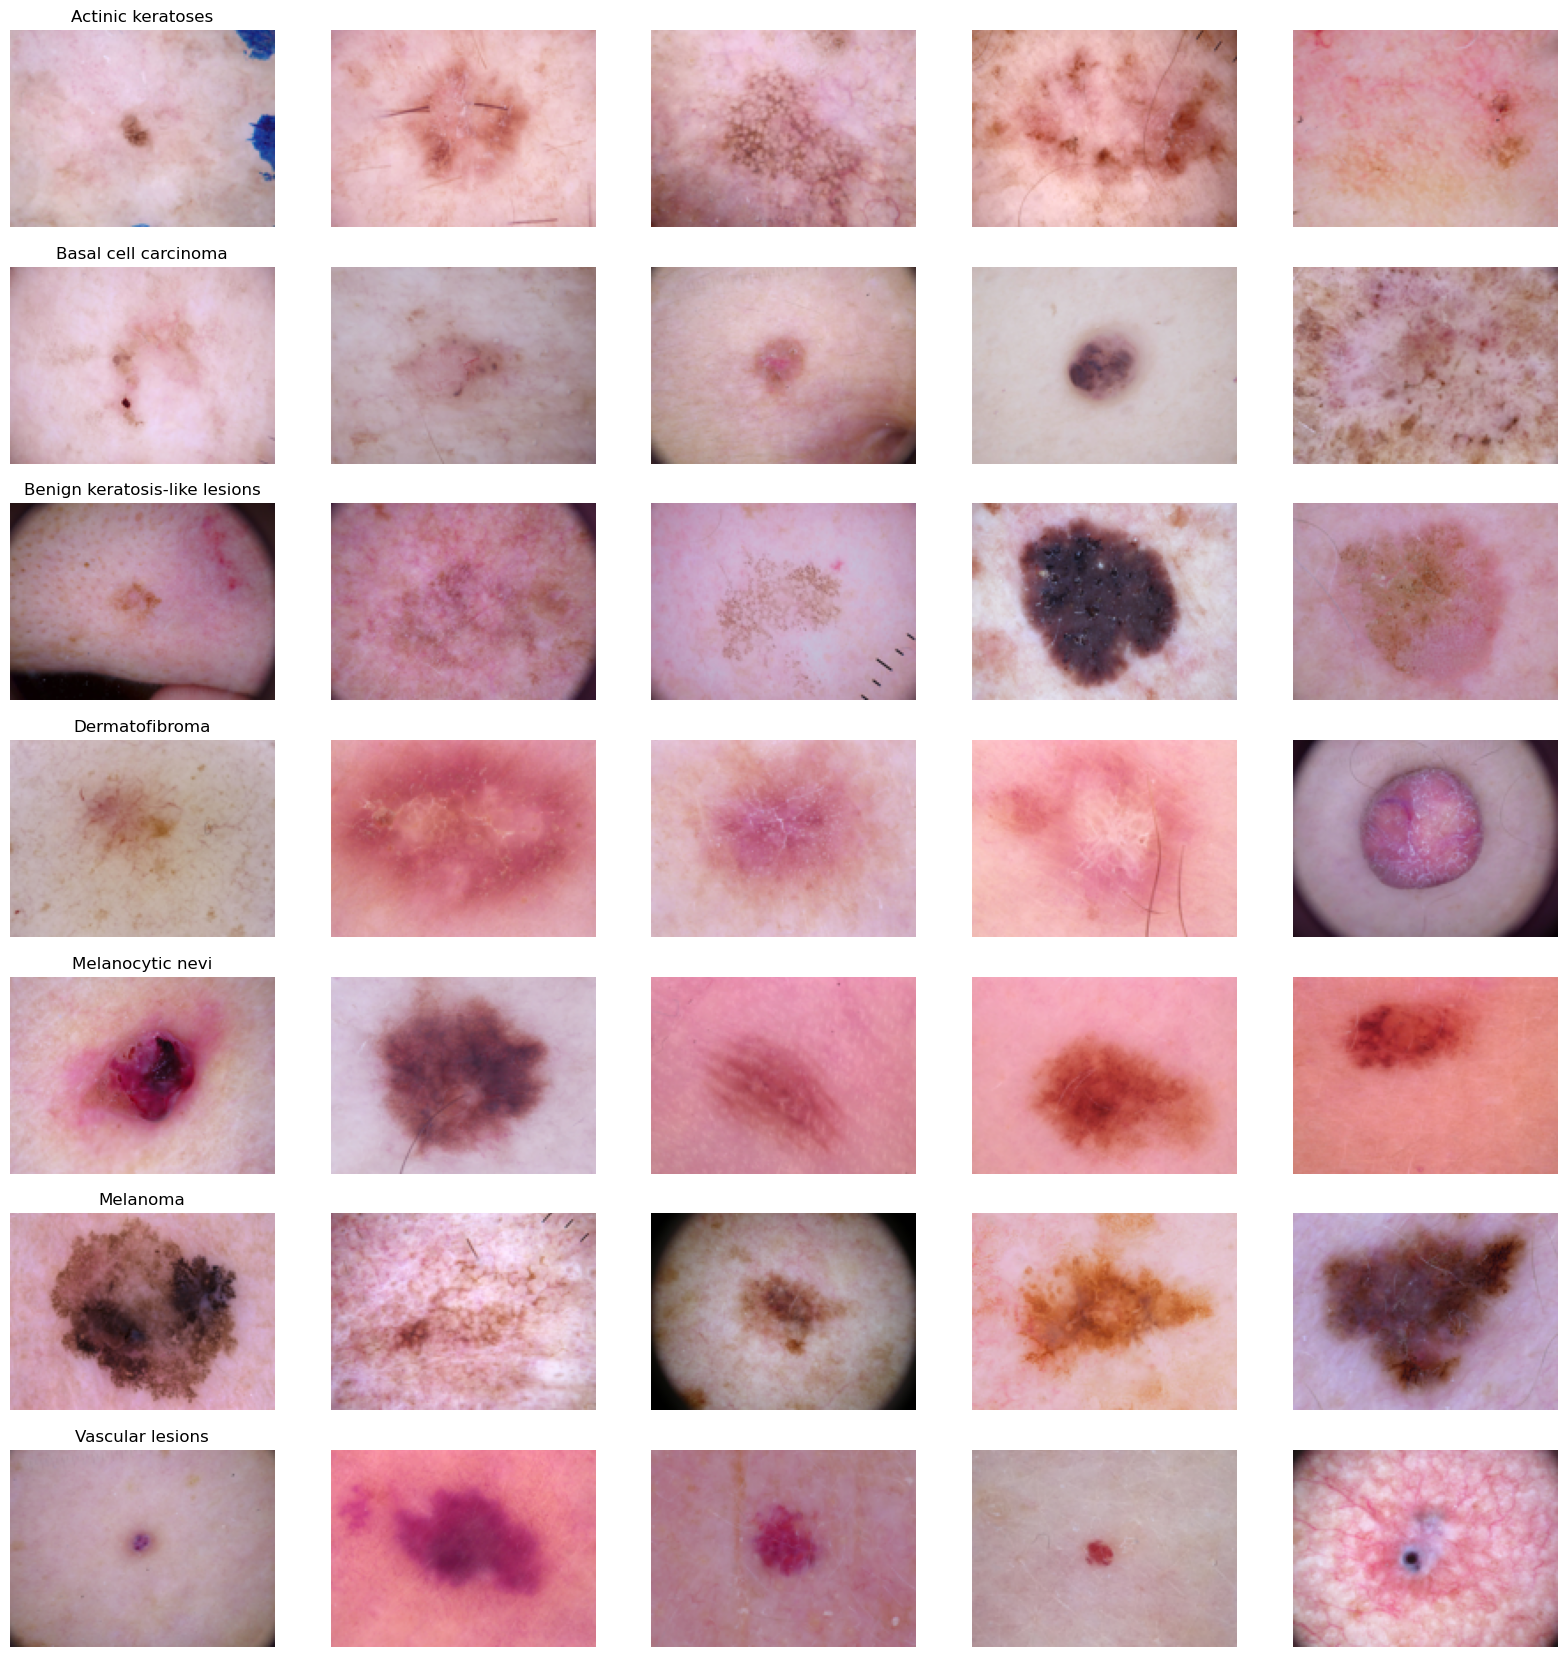

In [36]:
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, skin_df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=2018).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

os.makedirs('Photos', exist_ok=True)
fig.savefig('Photos/category_samples.png', dpi=300)

In [37]:
features = skin_df.drop(columns=['cell_type_idx'], axis=1)
target = skin_df['cell_type_idx']

In [38]:
num_classes = 7
target_encoded = to_categorical(target, num_classes=num_classes)
print(target_encoded)

[[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


In [39]:
X_train, X_test, y_train, y_test = train_test_split(features, target_encoded, test_size=0.20, stratify=target_encoded)

In [40]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, stratify=y_train)

In [41]:
x_train_images = np.asarray(X_train['image'].tolist())
x_val_images = np.asarray(X_val['image'].tolist())
x_test_images = np.asarray(X_test['image'].tolist())

In [42]:
x_train_mean = np.mean(x_train_images)
x_train_std = np.std(x_train_images)

In [43]:
x_train_normalized = (x_train_images - x_train_mean) / x_train_std
x_val_normalized = (x_val_images - x_train_mean) / x_train_std
x_test_normalized = (x_test_images - x_train_mean) / x_train_std

In [44]:
input_shape = (int(width), int(height), 3)
x_train_normalized = x_train_normalized.reshape(x_train_normalized.shape[0], *input_shape)
x_val_normalized = x_val_normalized.reshape(x_val_normalized.shape[0], *input_shape)
x_test_normalized = x_test_normalized.reshape(x_test_normalized.shape[0], *input_shape)

In [45]:
augmented_data = ImageDataGenerator(
    featurewise_center=False, 
    samplewise_center=False, 
    featurewise_std_normalization=False, 
    samplewise_std_normalization=False, 
    zca_whitening=False, 
    zca_epsilon=1e-06, 
    rotation_range=20, 
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    brightness_range=None, 
    shear_range=0.1, 
    zoom_range=0.1, 
    channel_shift_range=0.1, 
    fill_mode='nearest', 
    cval=0.0, 
    horizontal_flip=False, 
    vertical_flip=False, 
    rescale=None, 
    preprocessing_function=None, 
    data_format='channels_last', 
    validation_split=0.0, 
    interpolation_order=1, 
    dtype='float32'
)

In [46]:
augmented_data.fit(x_train_normalized)

# *Defining a Custom CNN Architecture Using Keras Sequential API*

In [47]:
model = Sequential()
model.add(Conv2D(16, kernel_size=(3,3), activation='relu', padding='same',
                 input_shape=input_shape))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(32, kernel_size=(3,3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2,2), padding='same'))

model.add(Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2,2), padding='same'))

model.add(Conv2D(128, kernel_size=(3,3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2,2), padding='same'))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 112, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 56, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 56, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 38, 28, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 38, 28, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 19, 14, 64)       0

In [48]:
optimizer = Adam(lr=0.001)

c:\Users\deepa\anaconda3\envs\dplrn\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [49]:
loss = "categorical_crossentropy"

In [50]:
metrics = ["accuracy", 'mse', 'mape', rmse]

In [51]:
model.compile(optimizer = optimizer , loss = loss, metrics = metrics)

In [52]:
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5, min_lr=0.00001)

In [53]:
skin_df.loc[skin_df['dx'] == 'akiec', ['cell_type', 'cell_type_idx']].head(1)
skin_df.loc[skin_df['dx'] == 'bcc', ['cell_type', 'cell_type_idx']].head(1)
skin_df.loc[skin_df['dx'] == 'bkl', ['cell_type', 'cell_type_idx']].head(1)
skin_df.loc[skin_df['dx'] == 'df', ['cell_type', 'cell_type_idx']].head(1)
skin_df.loc[skin_df['dx'] == 'nv', ['cell_type', 'cell_type_idx']].head(1)
skin_df.loc[skin_df['dx'] == 'mel', ['cell_type', 'cell_type_idx']].head(1)
skin_df.loc[skin_df['dx'] == 'vasc', ['cell_type', 'cell_type_idx']].head(1)

cell_type  cell_type_idx
9687  Actinic keratoses              0

cell_type  cell_type_idx
2462  Basal cell carcinoma              1

cell_type  cell_type_idx
0  Benign keratosis-like lesions              2

cell_type  cell_type_idx
1095  Dermatofibroma              3

cell_type  cell_type_idx
64  Melanocytic nevi              4

cell_type  cell_type_idx
1211  Melanoma              5

cell_type  cell_type_idx
2320  Vascular lesions              6

In [54]:
class_weights = {
    0: 1.0,  # akiec
    1: 1.0,  # bcc
    2: 1.0,  # bkl
    3: 1.0,  # df
    4: 3.0,  # nv (Try to make the model more sensitive to Melanocytic nevi)
    5: 1.0,  # mel
    6: 1.0,  # vasc
}

In [55]:
epochs = 50
batch_size = 10
steps_per_epoch = len(x_train_normalized) / 10

In [56]:
# Ensure the folder exists
os.makedirs('logs', exist_ok=True)
time_callback = TimeHistory()
csv_logger = CSVLogger('logs/original_cnn_training.log', separator=',', append=False)

history = model.fit(
    augmented_data.flow(x_train_normalized, y_train, batch_size=batch_size),
    epochs=epochs,
    verbose=1,
    class_weight=class_weights,
    validation_data=(x_val_normalized, y_val),
    steps_per_epoch=steps_per_epoch,
    callbacks=[reduce_lr, time_callback, csv_logger]
)

Epoch 1/50
478/478 [==============================] - 17s 30ms/step - loss: 1.1903 - accuracy: 0.7222 - mse: 0.0625 - mape: 48285608.0000 - rmse: 0.1603 - val_loss: 1.1338 - val_accuracy: 0.7232 - val_mse: 0.0666 - val_mape: 41758580.0000 - val_rmse: 0.1462 - lr: 0.0010
Epoch 2/50
478/478 [==============================] - 14s 29ms/step - loss: 1.0492 - accuracy: 0.7230 - mse: 0.0579 - mape: 45741404.0000 - rmse: 0.1507 - val_loss: 0.9220 - val_accuracy: 0.7232 - val_mse: 0.0580 - val_mape: 46118852.0000 - val_rmse: 0.1541 - lr: 0.0010
Epoch 3/50
478/478 [==============================] - 14s 29ms/step - loss: 0.9894 - accuracy: 0.7238 - mse: 0.0558 - mape: 44595160.0000 - rmse: 0.1467 - val_loss: 0.8826 - val_accuracy: 0.7224 - val_mse: 0.0549 - val_mape: 46184020.0000 - val_rmse: 0.1525 - lr: 0.0010
Epoch 4/50
478/478 [==============================] - ETA: 0s - loss: 0.9661 - accuracy: 0.7243 - mse: 0.0547 - mape: 44108028.0000 - rmse: 0.1449
Epoch 4: ReduceLROnPlateau reducing lear

In [57]:
print("\nTotal Time:", sum(time_callback.times), "s\n")


Total Time: 695.7687191963196 s



In [58]:
os.makedirs('Models', exist_ok=True)
model.save('Models/original_cnn_model.h5')
print("Saved entire model file to disk")

Saved entire model file to disk


In [59]:
# serialize model to JSON
model_json = model.to_json()
with open('Models/original_cnn_model.h5.json', "w") as json_file:
    json_file.write(model_json)
print("Saved model's architecture to disk")

# serialize weights to HDF5
model.save_weights('Models/original_cnn_model.h5')
print("Saved model's weights to disk")

4769

Saved model's architecture to disk
Saved model's weights to disk


In [60]:
loading_dependencies = {
    'rmse': rmse
}

In [61]:
from keras.models import load_model
from keras.models import model_from_json

# Method to load the model
try:
    # Attempt to load the entire model (architecture + weights)
    model = load_model('Models/original_cnn_model.h5', custom_objects=loading_dependencies)
    print("Loaded the entire model from disk")
except ValueError as e:
    print("Error loading the full model:", e)
    print("Trying to load model weights only...")

    # Define your model architecture (replace this with your specific model definition)
    with open('Models/original_cnn_model.h5.json', 'r') as json_file:
        model_json = json_file.read()
    model = model_from_json(model_json)
    print("Loaded model architecture from JSON.")

    # Load weights into the model
    model.load_weights('Models/original_cnn_model.h5')
    print("Loaded weights into the model.")

Error loading the full model: No model config found in the file at <tensorflow.python.platform.gfile.GFile object at 0x0000023B5384EE20>.
Trying to load model weights only...
Loaded model architecture from JSON.
Loaded weights into the model.


In [62]:
model_log_data = pd.read_csv('logs/original_cnn_training.log', sep=',', engine='python')

In [63]:
model_name = "BasicCNN"

In [64]:
train_val_accuracy_detailed(model, x_train_normalized, x_val_normalized, y_train, y_val)

Model is not compiled. Compiling now...
Model compiled successfully.
Available devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
38/38 [==============================] - 0s 5ms/step - loss: 0.7611 - accuracy: 0.7701 - mse: 0.0474 - mape: 36045504.0000 - root_mean_squared_error: 0.2177
Train Loss: 0.5790287256240845
Train Accuracy: 80.84%
Train RMSE: 0.198619082570076
Train MSE: 0.039449553936719894
Train MAPE: 31766306.0

Validation Loss: 0.7611098289489746
Validation Accuracy: 77.01%
Validation RMSE: 0.2177269458770752
Validation MSE: 0.047405026853084564
Validation MAPE: 36045504.0



In [65]:
test_acc = test_accuracy(model, x_test_normalized, y_test)

GPU detected. Using GPU for evaluation.
47/47 [==============================] - 0s 7ms/step - loss: 0.7016 - accuracy: 0.7718 - mse: 0.0453 - mape: 34905732.0000 - root_mean_squared_error: 0.2129

Test Set Accuracy:  77.17536687850952 % 
Test Set Loss: 0.7016231417655945 
Test Set RMSE: 0.21287283301353455 
Test Set MSE: 0.04531484469771385 
Test Set MAPE: 34905732.0


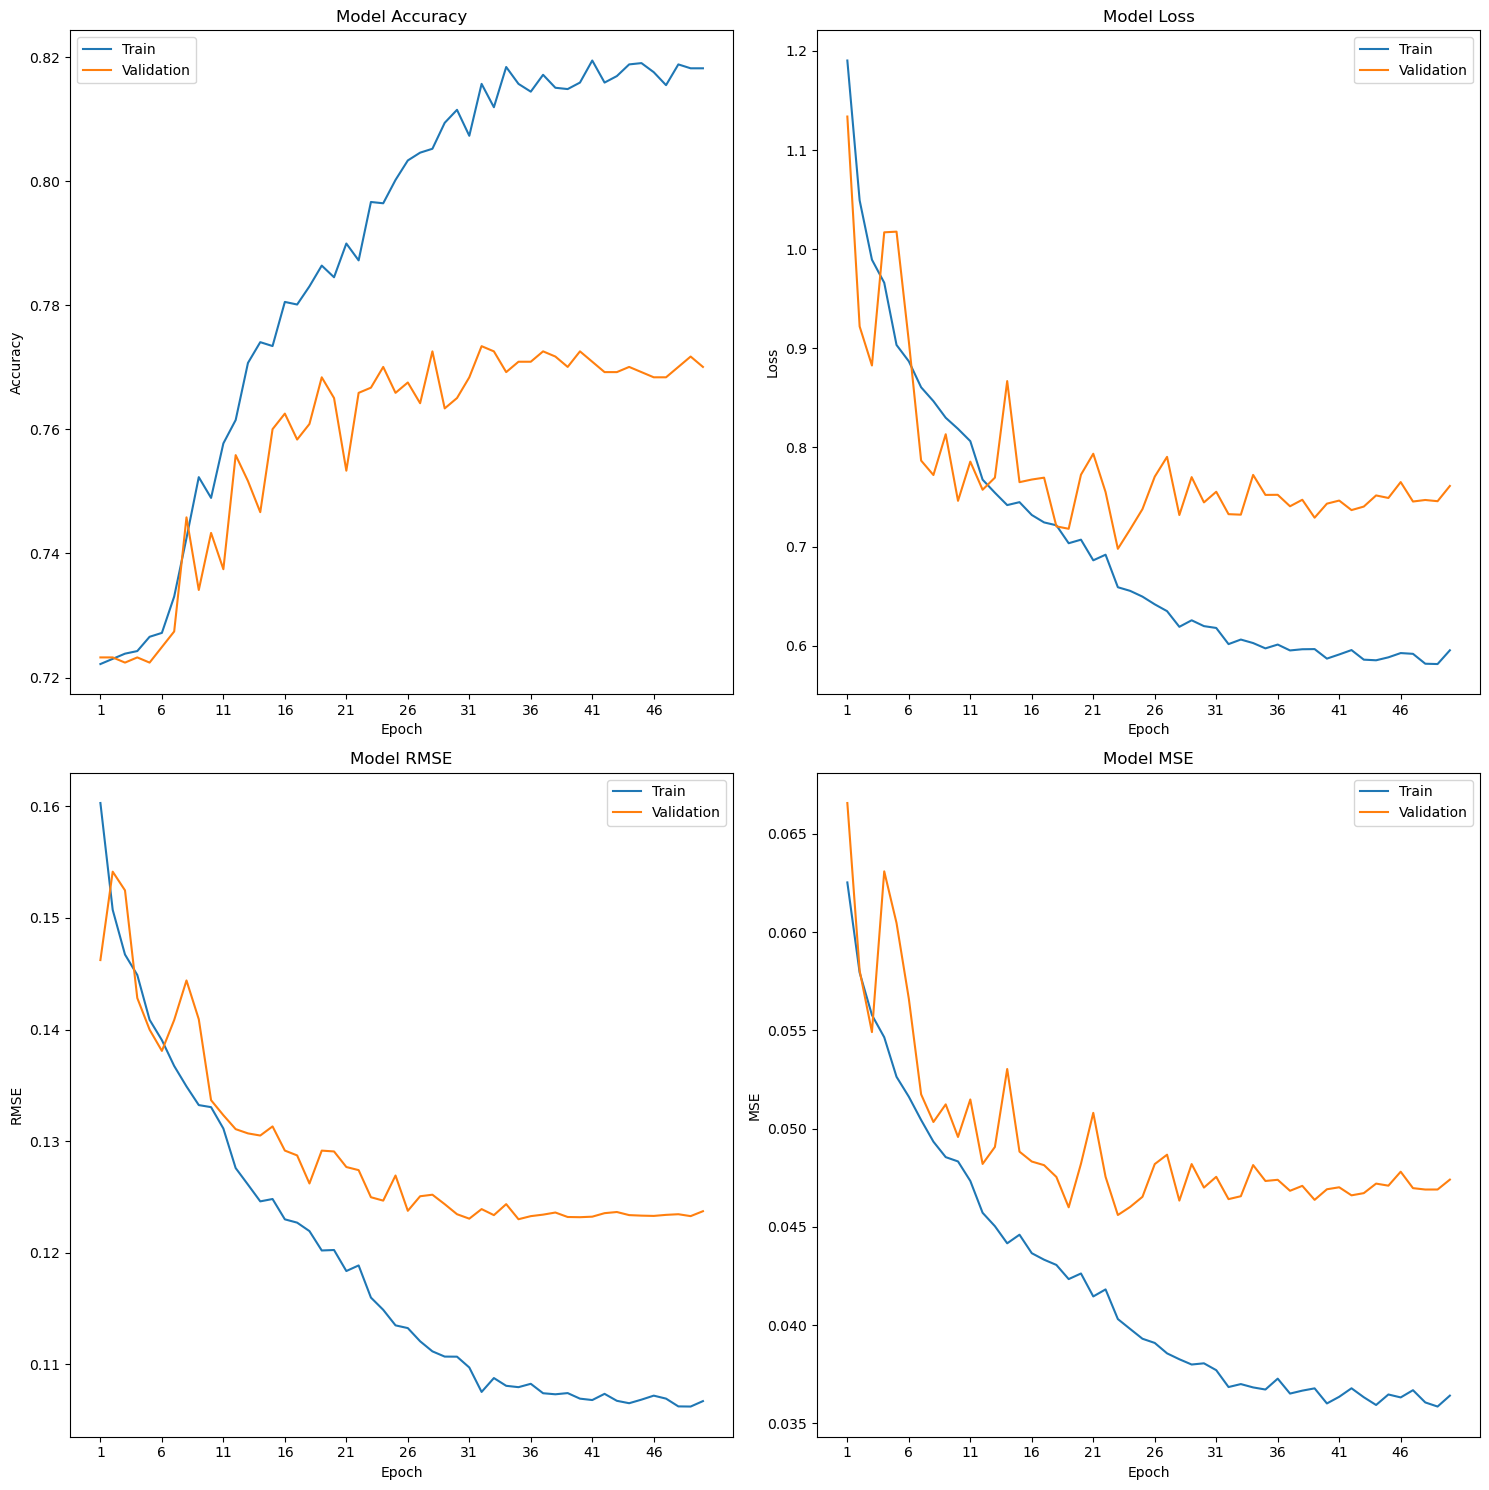

In [66]:
plot_model_history(history, "BasicCNN")

GPU detected. Using GPU for predictions.
47/47 [==============================] - 0s 4ms/step


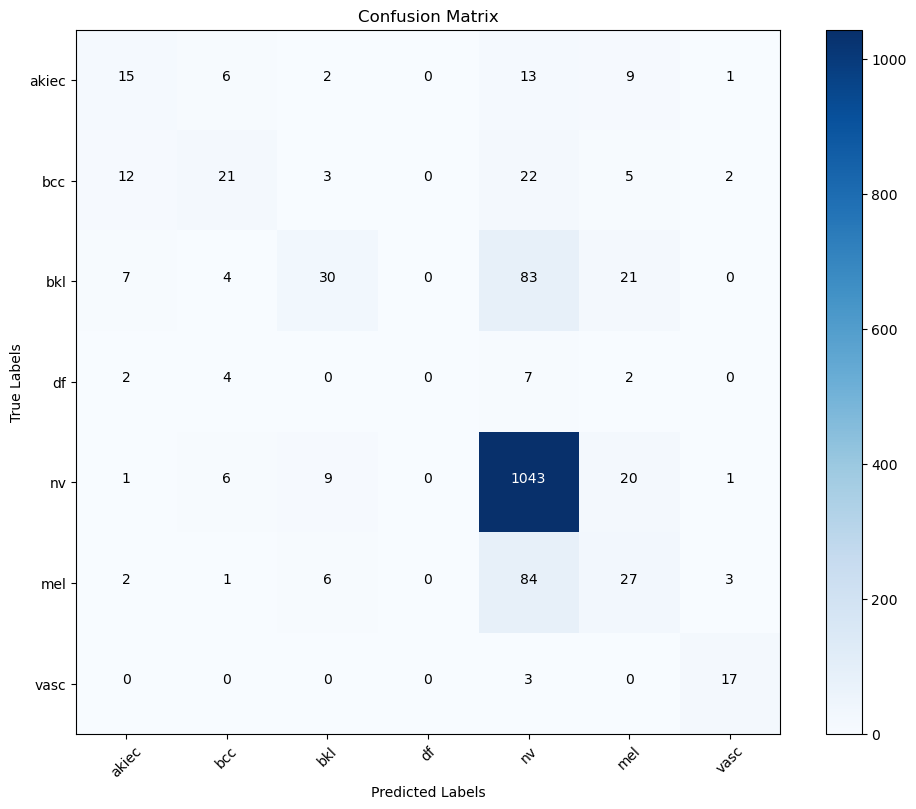

In [67]:
create_confusion_matrix(model, x_test_normalized, y_test, cm_plot_labels, model_name)

In [68]:
gen_classification_report(model, x_test_normalized, y_test, cm_plot_labels)

GPU detected. Using GPU for predictions.
47/47 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

       akiec       0.38      0.33      0.35        46
         bcc       0.50      0.32      0.39        65
         bkl       0.60      0.21      0.31       145
          df       0.00      0.00      0.00        15
          nv       0.83      0.97      0.89      1080
         mel       0.32      0.22      0.26       123
        vasc       0.71      0.85      0.77        20

    accuracy                           0.77      1494
   macro avg       0.48      0.41      0.43      1494
weighted avg       0.73      0.77      0.74      1494



c:\Users\deepa\anaconda3\envs\dplrn\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\deepa\anaconda3\envs\dplrn\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\deepa\anaconda3\envs\dplrn\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


GPU detected. Using GPU for predictions.
47/47 [==============================] - 0s 4ms/step


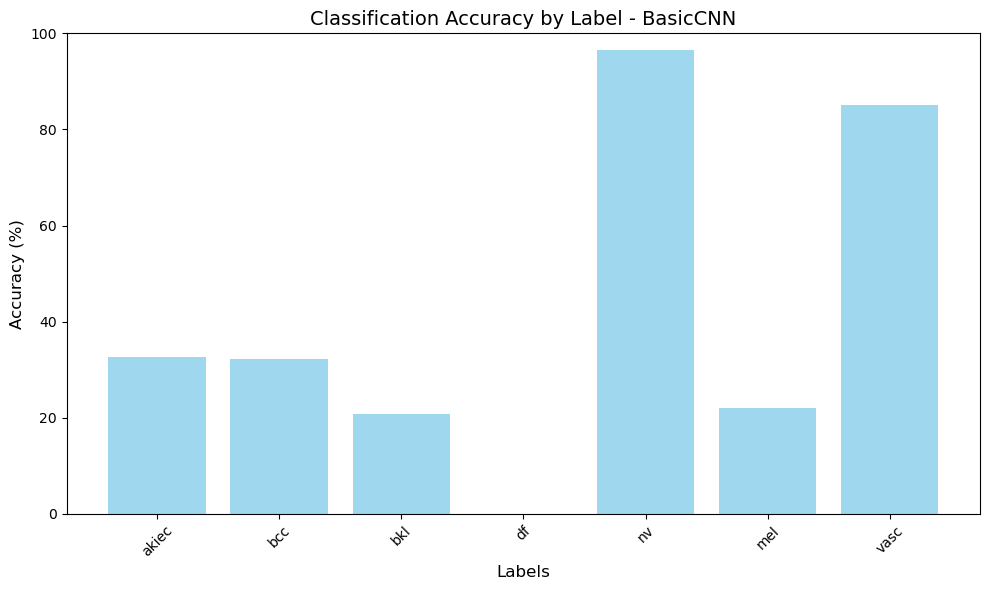

In [69]:
plot_label_classification_acc(model, x_test_normalized, y_test, cm_plot_labels, model_name)

# *InceptionV3*

In [70]:
base_inception_model = InceptionV3(include_top=False, weights="imagenet", input_shape=input_shape)

In [71]:
inception_model = Sequential()
inception_model = add_cnn_layers(base_inception_model, inception_model)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 3, 2, 2048)        21802784  
                                                                 
 conv2d_98 (Conv2D)          (None, 3, 2, 64)          1179712   
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 1, 1, 64)         0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 1, 1, 64)          0         
                                                                 
 flatten_1 (Flatten)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 128)               8320      
                                                      

In [72]:
inception_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [73]:
inception_time_callback = TimeHistory()
inception_csv_logger = CSVLogger('logs/inception_training.log', separator=',', append=False)
inception_history = inception_model.fit_generator(
    augmented_data.flow(x_train_normalized, y_train, batch_size=batch_size),
    epochs=epochs,
    verbose=1,
    class_weight=class_weights,
    validation_data=(x_val_normalized, y_val),
    steps_per_epoch=steps_per_epoch,
    callbacks=[reduce_lr, inception_time_callback, inception_csv_logger]
)

Epoch 1/50


C:\Users\deepa\AppData\Local\Temp\ipykernel_10924\1256078263.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  inception_history = inception_model.fit_generator(


478/478 [==============================] - 33s 53ms/step - loss: 1.7349 - accuracy: 0.6814 - mse: 0.0700 - mape: 59519184.0000 - rmse: 0.1916 - val_loss: 1.2688 - val_accuracy: 0.7232 - val_mse: 0.0629 - val_mape: 42607428.0000 - val_rmse: 0.1440 - lr: 1.0000e-05
Epoch 2/50
478/478 [==============================] - 23s 48ms/step - loss: 1.3367 - accuracy: 0.7132 - mse: 0.0605 - mape: 51342800.0000 - rmse: 0.1644 - val_loss: 1.3207 - val_accuracy: 0.7232 - val_mse: 0.0620 - val_mape: 41672304.0000 - val_rmse: 0.1409 - lr: 1.0000e-05
Epoch 3/50
478/478 [==============================] - 23s 47ms/step - loss: 1.2586 - accuracy: 0.7184 - mse: 0.0583 - mape: 49432748.0000 - rmse: 0.1580 - val_loss: 1.2454 - val_accuracy: 0.7232 - val_mse: 0.0617 - val_mape: 41208528.0000 - val_rmse: 0.1396 - lr: 1.0000e-05
Epoch 4/50
478/478 [==============================] - 23s 48ms/step - loss: 1.2250 - accuracy: 0.7215 - mse: 0.0578 - mape: 48430552.0000 - rmse: 0.1552 - val_loss: 1.0582 - val_accuracy

In [74]:
print("\nTotal Time:", sum(inception_time_callback.times), "s\n")


Total Time: 1160.0694379806519 s



In [75]:
inception_model.save('Models/inception_model_50epochs.h5')
print("Saved entire model file to disk")

Saved entire model file to disk


In [76]:
inception_model = load_model('Models/inception_model_50epochs.h5', custom_objects=loading_dependencies)
print("Loaded entire model file from disk")

Loaded entire model file from disk


In [77]:
inception_log_data = pd.read_csv('logs/inception_training.log', sep=',', engine='python')

In [78]:
inception_model_name = "InceptionV3"

In [79]:
train_val_accuracy_detailed(inception_model, x_train_normalized, x_val_normalized, y_train, y_val)

Available devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
38/38 [==============================] - 1s 22ms/step - loss: 0.7366 - accuracy: 0.7600 - mse: 0.0485 - mape: 38916728.0000 - rmse: 0.1277
Train Loss: 0.5945236682891846
Train Accuracy: 78.68%
Train RMSE: 0.11243661493062973
Train MSE: 0.04153931140899658
Train MAPE: 34596216.0

Validation Loss: 0.7365580201148987
Validation Accuracy: 76.00%
Validation RMSE: 0.12774576246738434
Validation MSE: 0.04852652922272682
Validation MAPE: 38916728.0



In [80]:
test_accuracy(inception_model, x_test_normalized, y_test)

GPU detected. Using GPU for evaluation.
47/47 [==============================] - 2s 37ms/step - loss: 0.7135 - accuracy: 0.7604 - mse: 0.0466 - mape: 37143776.0000 - rmse: 0.1219

Test Set Accuracy:  76.03748440742493 % 
Test Set Loss: 0.7134947776794434 
Test Set RMSE: 0.12187487632036209 
Test Set MSE: 0.046643566340208054 
Test Set MAPE: 37143776.0


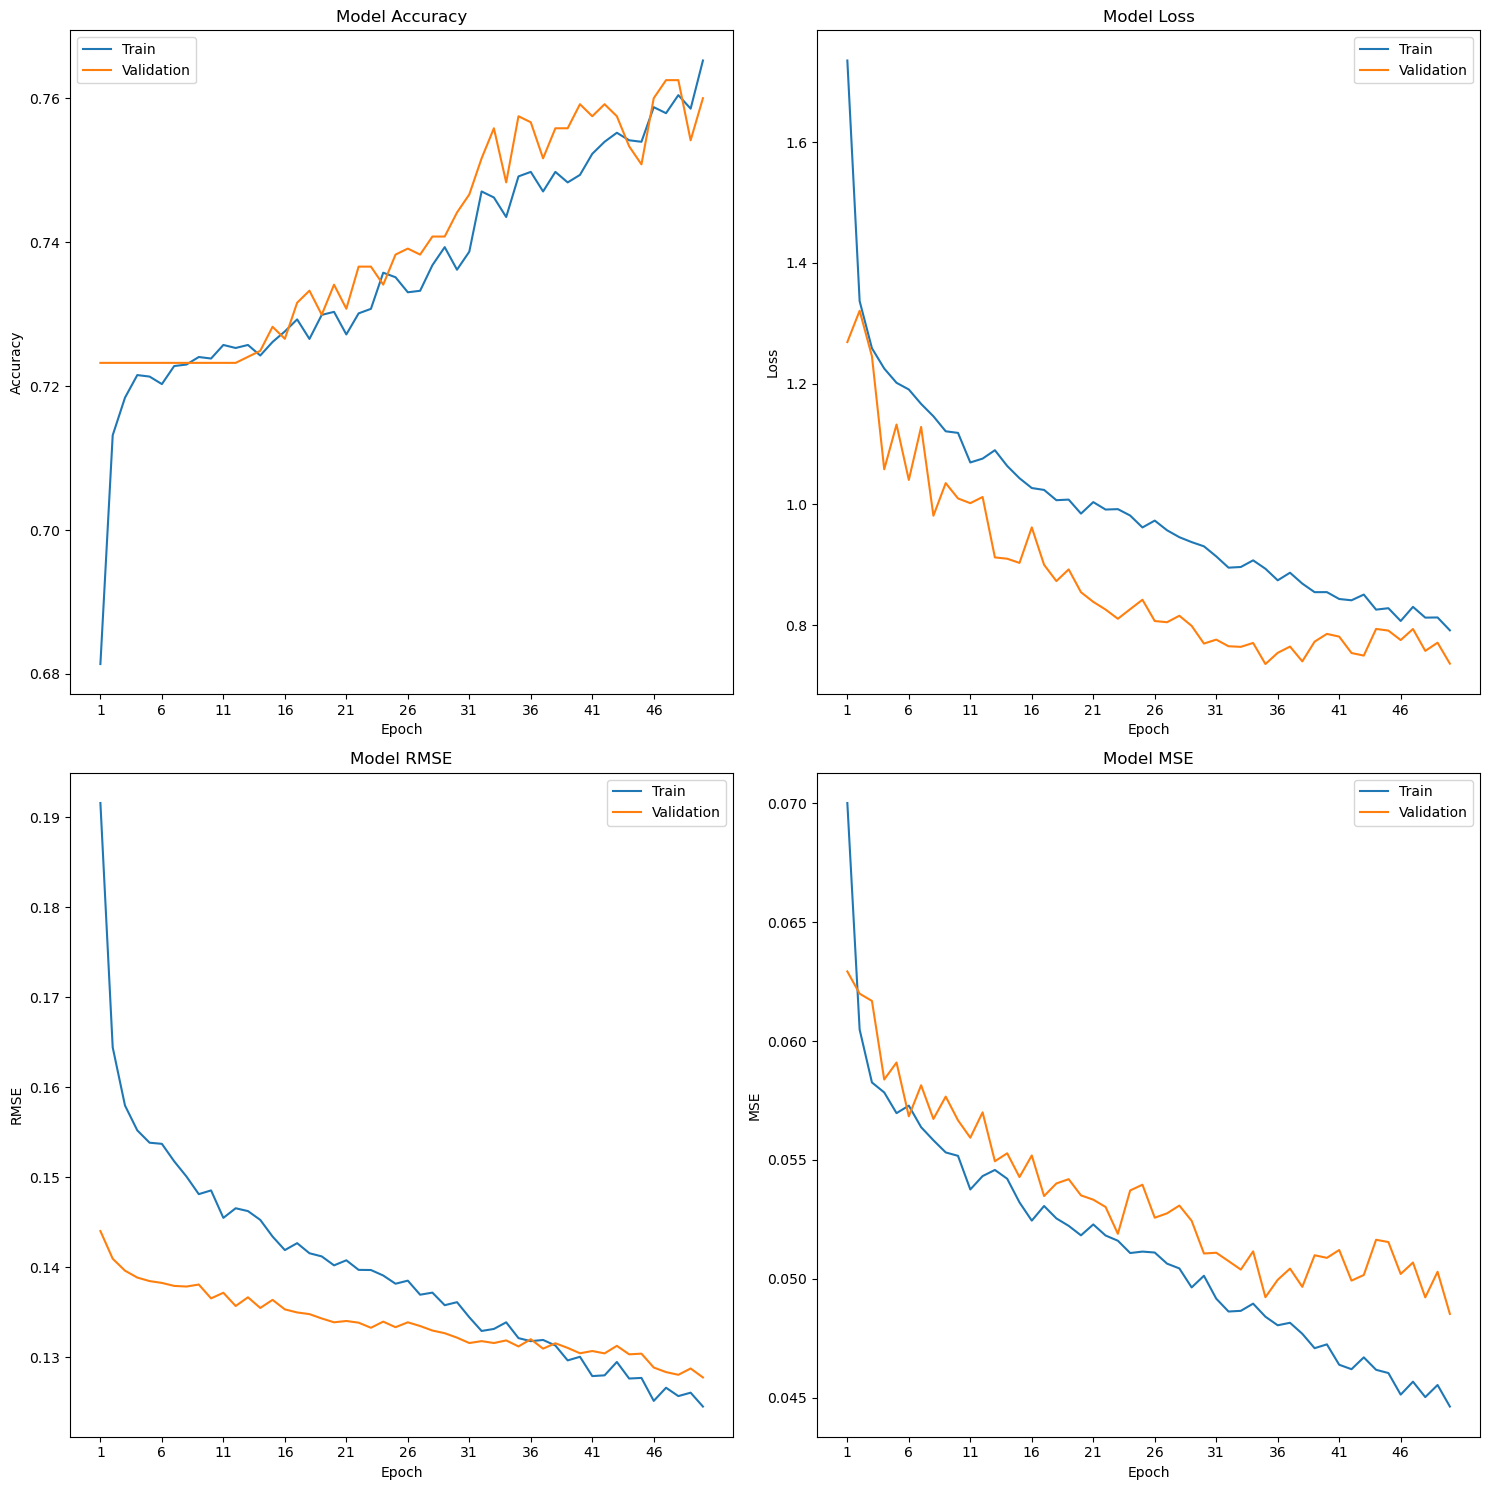

In [81]:
plot_model_history(inception_history, "InceptionV3")

GPU detected. Using GPU for predictions.
47/47 [==============================] - 2s 20ms/step


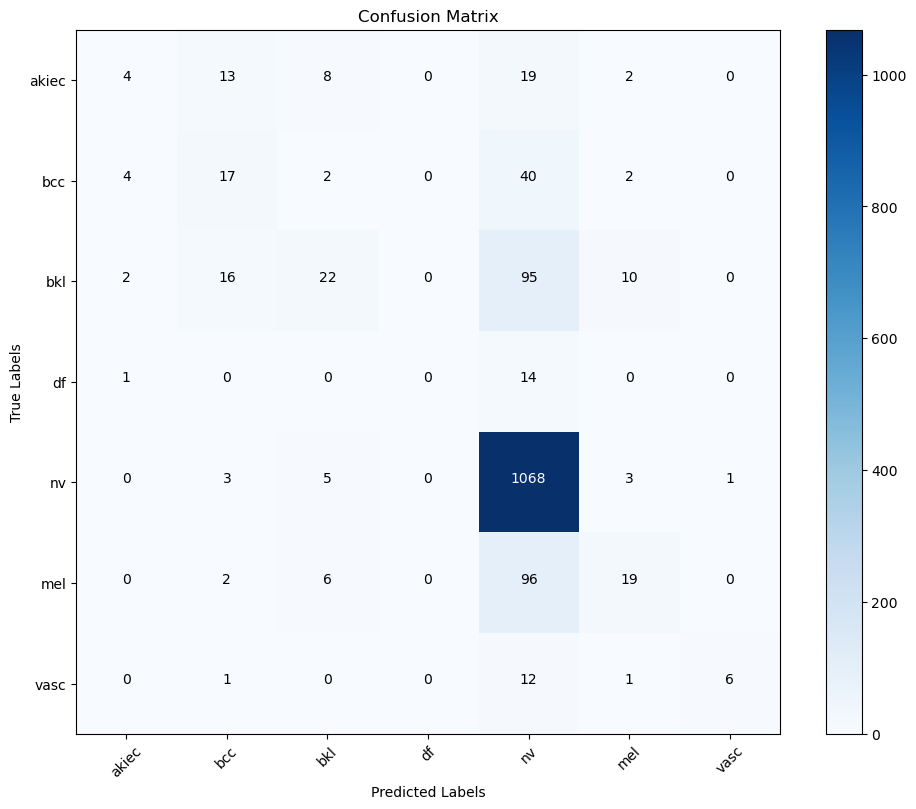

In [82]:
create_confusion_matrix(inception_model, x_test_normalized, y_test, cm_plot_labels, inception_model_name)

In [83]:
gen_classification_report(inception_model, x_test_normalized, y_test, cm_plot_labels)

GPU detected. Using GPU for predictions.
47/47 [==============================] - 1s 19ms/step
              precision    recall  f1-score   support

       akiec       0.36      0.09      0.14        46
         bcc       0.33      0.26      0.29        65
         bkl       0.51      0.15      0.23       145
          df       0.00      0.00      0.00        15
          nv       0.79      0.99      0.88      1080
         mel       0.51      0.15      0.24       123
        vasc       0.86      0.30      0.44        20

    accuracy                           0.76      1494
   macro avg       0.48      0.28      0.32      1494
weighted avg       0.70      0.76      0.70      1494



c:\Users\deepa\anaconda3\envs\dplrn\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\deepa\anaconda3\envs\dplrn\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\deepa\anaconda3\envs\dplrn\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


GPU detected. Using GPU for predictions.
47/47 [==============================] - 1s 19ms/step


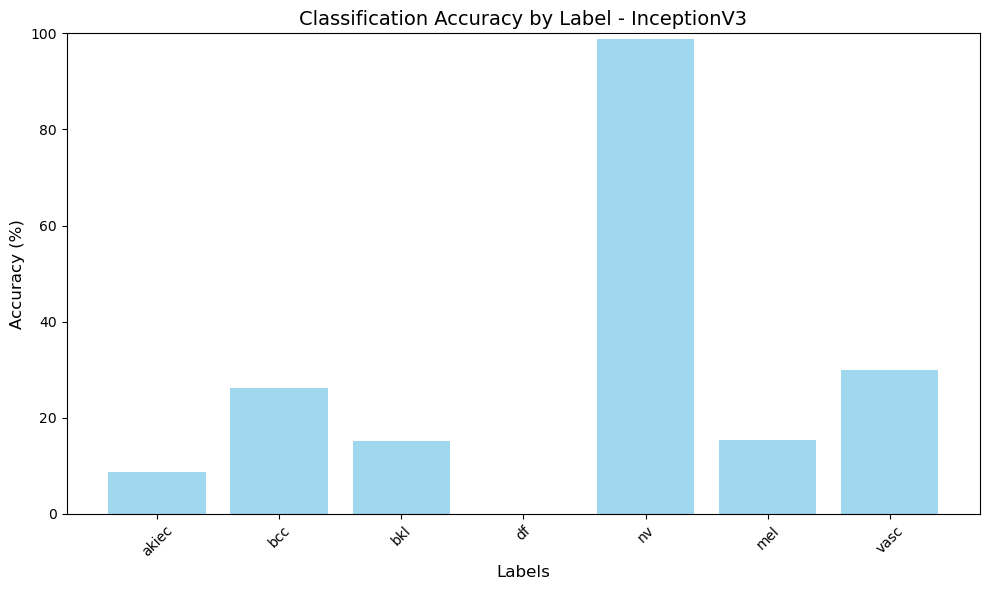

In [84]:
plot_label_classification_acc(inception_model, x_test_normalized, y_test, cm_plot_labels, inception_model_name)

# *ResNet152V2*

In [85]:
base_res_model = ResNet152V2(include_top=False, weights='imagenet', input_tensor=None, input_shape=input_shape, pooling=None, classes=1000)

In [86]:
res_model = Sequential()
res_model = add_cnn_layers(base_res_model, res_model)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, 5, 4, 2048)        58331648  
                                                                 
 conv2d_99 (Conv2D)          (None, 5, 4, 64)          1179712   
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 2, 2, 64)         0         
 g2D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 2, 2, 64)          0         
                                                                 
 flatten_2 (Flatten)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 128)               32896     
                                                      

In [87]:
res_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [88]:
res_time_callback = TimeHistory()
res_csv_logger = CSVLogger('logs/res_training.log', separator=',', append=False)
res_history = res_model.fit_generator(
    augmented_data.flow(x_train_normalized, y_train, batch_size=batch_size),
    epochs=epochs,
    verbose=1,
    class_weight=class_weights,
    validation_data=(x_val_normalized, y_val),
    steps_per_epoch=steps_per_epoch,
    callbacks=[reduce_lr, res_time_callback, res_csv_logger]
)

Epoch 1/50


C:\Users\deepa\AppData\Local\Temp\ipykernel_10924\2378191805.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  res_history = res_model.fit_generator(


478/478 [==============================] - 72s 122ms/step - loss: 1.8579 - accuracy: 0.6837 - mse: 0.0713 - mape: 52867332.0000 - rmse: 0.1777 - val_loss: 1.0535 - val_accuracy: 0.7232 - val_mse: 0.0614 - val_mape: 43908988.0000 - val_rmse: 0.1459 - lr: 1.0000e-05
Epoch 2/50
478/478 [==============================] - 56s 116ms/step - loss: 1.3738 - accuracy: 0.7157 - mse: 0.0628 - mape: 48668036.0000 - rmse: 0.1605 - val_loss: 0.9834 - val_accuracy: 0.7232 - val_mse: 0.0593 - val_mape: 43174068.0000 - val_rmse: 0.1432 - lr: 1.0000e-05
Epoch 3/50
478/478 [==============================] - 56s 116ms/step - loss: 1.2747 - accuracy: 0.7207 - mse: 0.0607 - mape: 47938448.0000 - rmse: 0.1573 - val_loss: 0.9657 - val_accuracy: 0.7232 - val_mse: 0.0580 - val_mape: 43256864.0000 - val_rmse: 0.1424 - lr: 1.0000e-05
Epoch 4/50
478/478 [==============================] - 55s 116ms/step - loss: 1.2063 - accuracy: 0.7199 - mse: 0.0589 - mape: 47298736.0000 - rmse: 0.1542 - val_loss: 0.9638 - val_accu

In [89]:
print("\nTotal Time:", sum(res_time_callback.times), "s\n")


Total Time: 2819.7326278686523 s



In [90]:
res_model.save('Models/res_model_50epochs.h5')
print("Saved entire model file to disk")

Saved entire model file to disk


In [91]:
res_model = load_model('Models/res_model_50epochs.h5', custom_objects=loading_dependencies)
print("Loaded entire model file from disk")

Loaded entire model file from disk


In [92]:
res_log_data = pd.read_csv('logs/res_training.log', sep=',', engine='python')

In [93]:
res_model_name = "ResNet152V2"

In [94]:
train_val_accuracy_detailed(res_model, x_train_normalized, x_val_normalized, y_train, y_val)

Available devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
38/38 [==============================] - 3s 68ms/step - loss: 0.8329 - accuracy: 0.7784 - mse: 0.0472 - mape: 34810700.0000 - rmse: 0.1181
Train Loss: 0.3728458881378174
Train Accuracy: 85.54%
Train RMSE: 0.08054229617118835
Train MSE: 0.027694210410118103
Train MAPE: 24544226.0

Validation Loss: 0.8329018354415894
Validation Accuracy: 77.84%
Validation RMSE: 0.11805762350559235
Validation MSE: 0.04715429246425629
Validation MAPE: 34810700.0



In [95]:
test_accuracy(res_model, x_test_normalized, y_test)

GPU detected. Using GPU for evaluation.
47/47 [==============================] - 4s 78ms/step - loss: 0.7012 - accuracy: 0.7945 - mse: 0.0430 - mape: 32745702.0000 - rmse: 0.1098

Test Set Accuracy:  79.45113778114319 % 
Test Set Loss: 0.7012143731117249 
Test Set RMSE: 0.10975415259599686 
Test Set MSE: 0.042959798127412796 
Test Set MAPE: 32745702.0


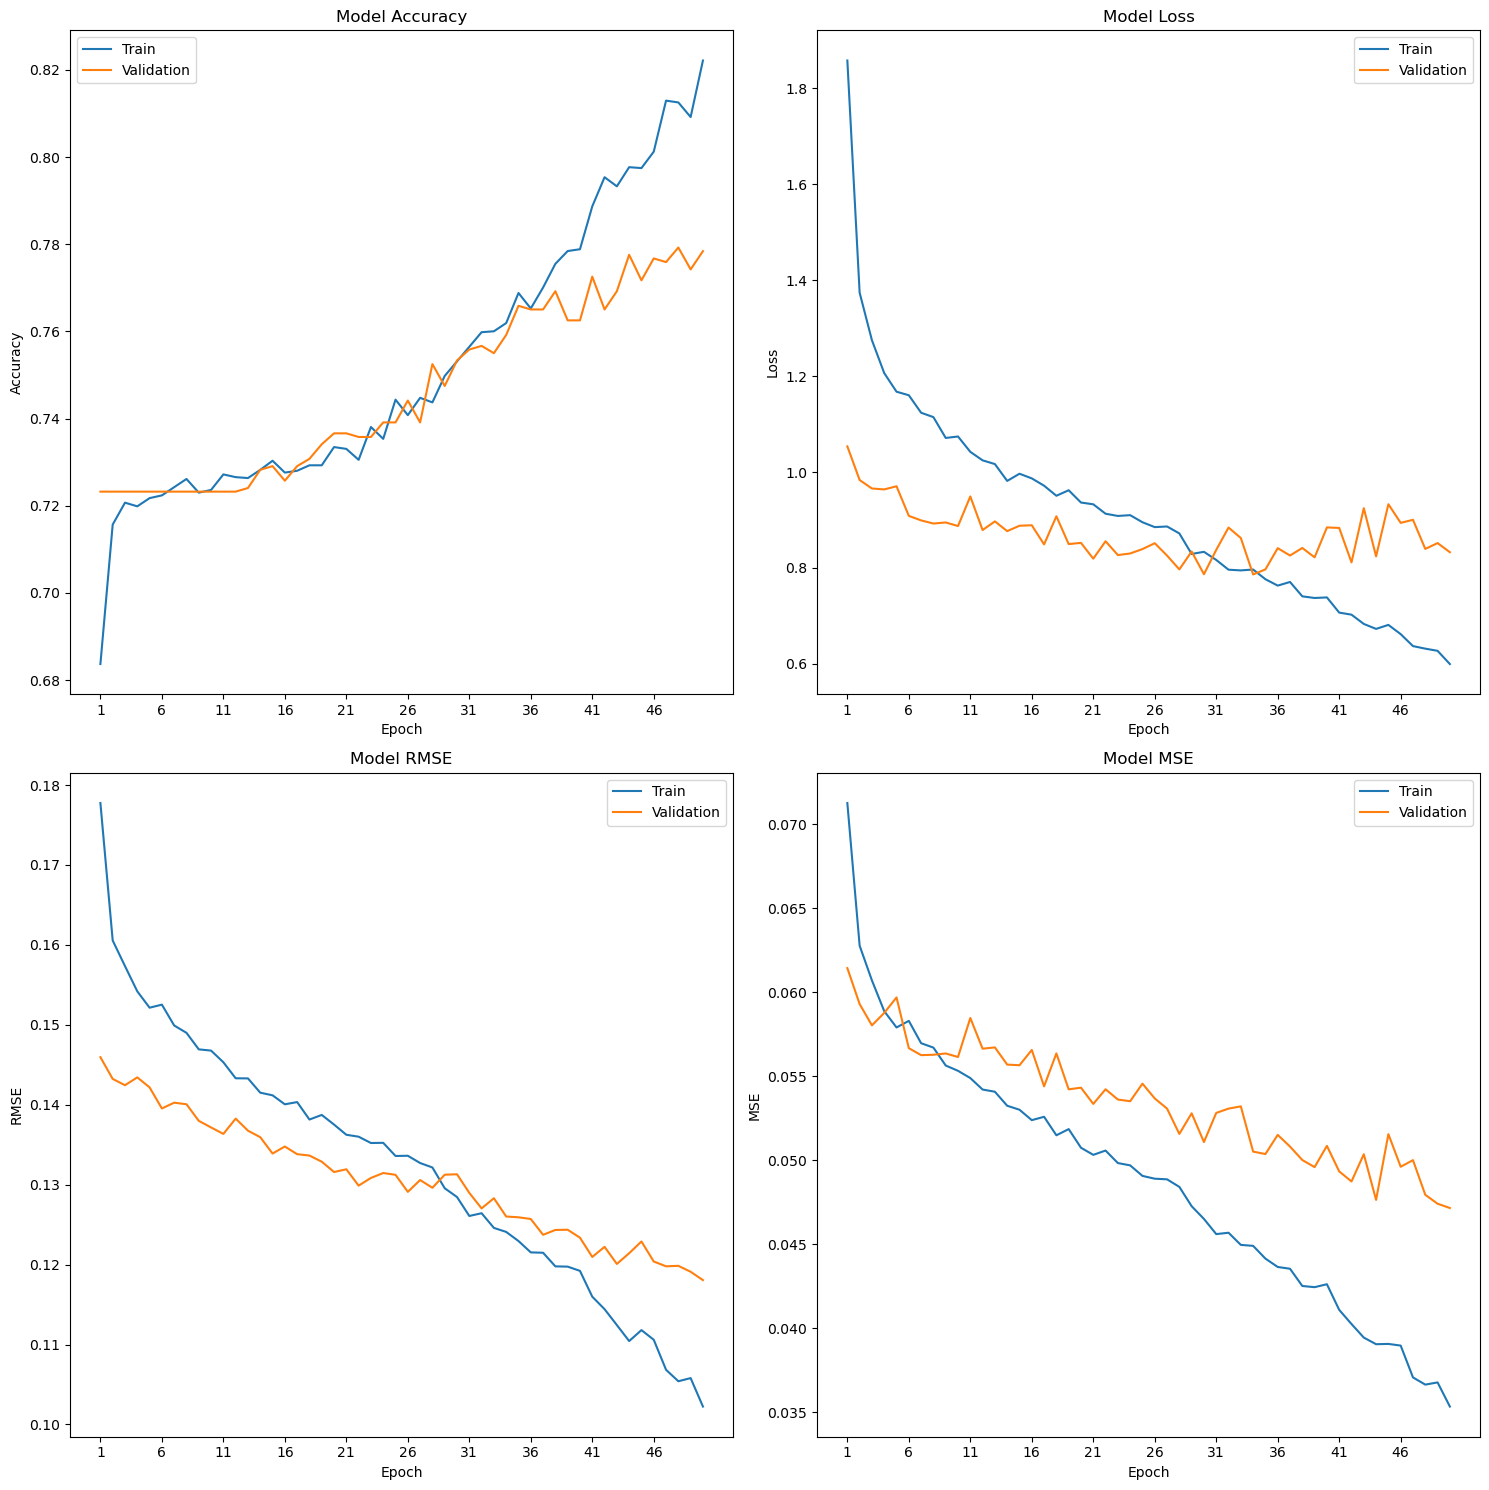

In [96]:
plot_model_history(res_history, "ResNet152V2")

GPU detected. Using GPU for predictions.
47/47 [==============================] - 5s 65ms/step


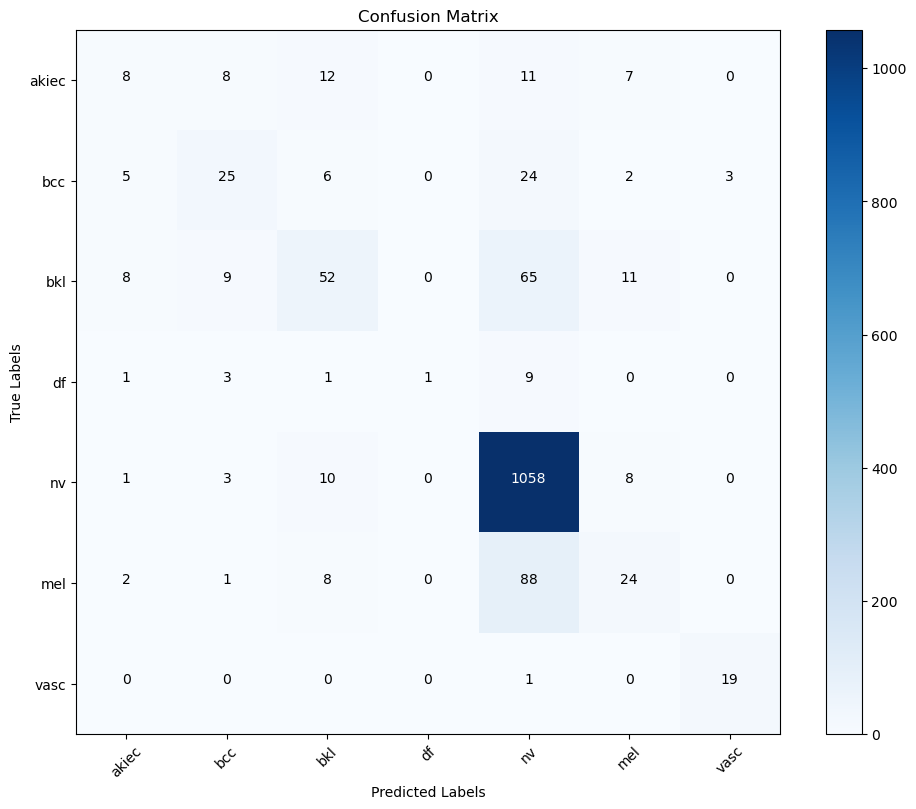

In [97]:
create_confusion_matrix(res_model, x_test_normalized, y_test, cm_plot_labels, res_model_name)

In [98]:
gen_classification_report(res_model, x_test_normalized, y_test, cm_plot_labels)

GPU detected. Using GPU for predictions.
47/47 [==============================] - 3s 63ms/step
              precision    recall  f1-score   support

       akiec       0.32      0.17      0.23        46
         bcc       0.51      0.38      0.44        65
         bkl       0.58      0.36      0.44       145
          df       1.00      0.07      0.12        15
          nv       0.84      0.98      0.91      1080
         mel       0.46      0.20      0.27       123
        vasc       0.86      0.95      0.90        20

    accuracy                           0.79      1494
   macro avg       0.65      0.44      0.47      1494
weighted avg       0.76      0.79      0.76      1494



GPU detected. Using GPU for predictions.
47/47 [==============================] - 3s 63ms/step


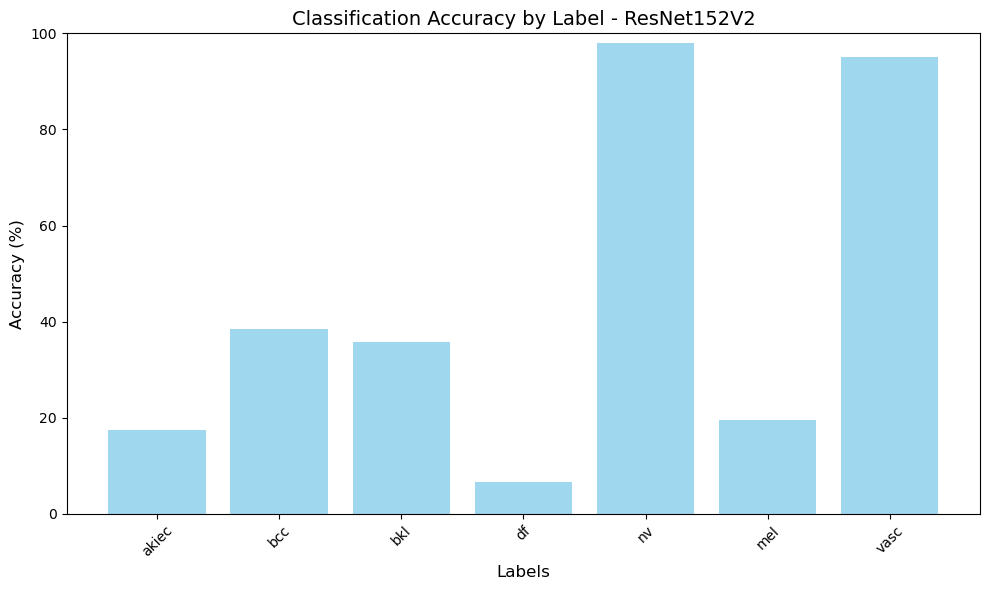

In [99]:
plot_label_classification_acc(res_model, x_test_normalized, y_test, cm_plot_labels, res_model_name)

# *VGG16*

In [100]:
base_vgg_model = VGG16(input_shape=input_shape, include_top=False, weights='imagenet', input_tensor=None, pooling=None, classes=1000)

In [101]:
vgg_model = Sequential()
vgg_model = add_cnn_layers(base_vgg_model, vgg_model)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 3, 512)         14714688  
                                                                 
 conv2d_100 (Conv2D)         (None, 4, 3, 64)          294976    
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 2, 1, 64)         0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 2, 1, 64)          0         
                                                                 
 flatten_3 (Flatten)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 128)               16512     
                                                      

In [102]:
vgg_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [103]:
vgg_time_callback = TimeHistory()
vgg_csv_logger = CSVLogger('logs/vgg_training.log', separator=',', append=False)
vgg_history = vgg_model.fit_generator(
    augmented_data.flow(x_train_normalized, y_train, batch_size=batch_size),
    epochs=epochs,
    verbose=1,
    class_weight=class_weights,
    validation_data=(x_val_normalized, y_val),
    steps_per_epoch=steps_per_epoch,
    callbacks=[reduce_lr, vgg_time_callback, vgg_csv_logger]
)

Epoch 1/50


C:\Users\deepa\AppData\Local\Temp\ipykernel_10924\2842054123.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  vgg_history = vgg_model.fit_generator(


478/478 [==============================] - 27s 50ms/step - loss: 1.4184 - accuracy: 0.7040 - mse: 0.0634 - mape: 52684320.0000 - rmse: 0.1698 - val_loss: 0.8706 - val_accuracy: 0.7232 - val_mse: 0.0552 - val_mape: 44813256.0000 - val_rmse: 0.1439 - lr: 1.0000e-05
Epoch 2/50
478/478 [==============================] - 22s 45ms/step - loss: 1.1856 - accuracy: 0.7251 - mse: 0.0568 - mape: 47658240.0000 - rmse: 0.1526 - val_loss: 0.9965 - val_accuracy: 0.7232 - val_mse: 0.0599 - val_mape: 40839460.0000 - val_rmse: 0.1374 - lr: 1.0000e-05
Epoch 3/50
478/478 [==============================] - 22s 45ms/step - loss: 1.1228 - accuracy: 0.7278 - mse: 0.0546 - mape: 46358152.0000 - rmse: 0.1481 - val_loss: 0.9518 - val_accuracy: 0.7258 - val_mse: 0.0580 - val_mape: 40430700.0000 - val_rmse: 0.1351 - lr: 1.0000e-05
Epoch 4/50
478/478 [==============================] - 22s 45ms/step - loss: 1.0462 - accuracy: 0.7291 - mse: 0.0531 - mape: 44854884.0000 - rmse: 0.1433 - val_loss: 1.1641 - val_accuracy

In [104]:
print("\nTotal Time:", sum(vgg_time_callback.times), "s\n")


Total Time: 1101.460491657257 s



In [105]:
vgg_model.save('Models/vgg_model_50epochs.h5')
print("Saved entire model file to disk")

Saved entire model file to disk


In [106]:
vgg_model = load_model('Models/vgg_model_50epochs.h5', custom_objects=loading_dependencies)
print("Loaded entire model file from disk")

Loaded entire model file from disk


In [107]:
vgg_log_data = pd.read_csv('logs/vgg_training.log', sep=',', engine='python')

In [108]:
vgg_model_name = "VGG16"

In [109]:
train_val_accuracy_detailed(vgg_model, x_train_normalized, x_val_normalized, y_train, y_val)

Available devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
38/38 [==============================] - 1s 28ms/step - loss: 1.2433 - accuracy: 0.7784 - mse: 0.0533 - mape: 33391516.0000 - rmse: 0.1186
Train Loss: 0.12396923452615738
Train Accuracy: 95.82%
Train RMSE: 0.03047533892095089
Train MSE: 0.0089619355276227
Train MAPE: 9135051.0

Validation Loss: 1.2432701587677002
Validation Accuracy: 77.84%
Validation RMSE: 0.11859706044197083
Validation MSE: 0.053260043263435364
Validation MAPE: 33391516.0



In [110]:
test_accuracy(vgg_model, x_test_normalized, y_test)

GPU detected. Using GPU for evaluation.
47/47 [==============================] - 2s 51ms/step - loss: 1.1454 - accuracy: 0.7972 - mse: 0.0486 - mape: 30481018.0000 - rmse: 0.1084

Test Set Accuracy:  79.71887588500977 % 
Test Set Loss: 1.1453957557678223 
Test Set RMSE: 0.10844193398952484 
Test Set MSE: 0.04864872619509697 
Test Set MAPE: 30481018.0


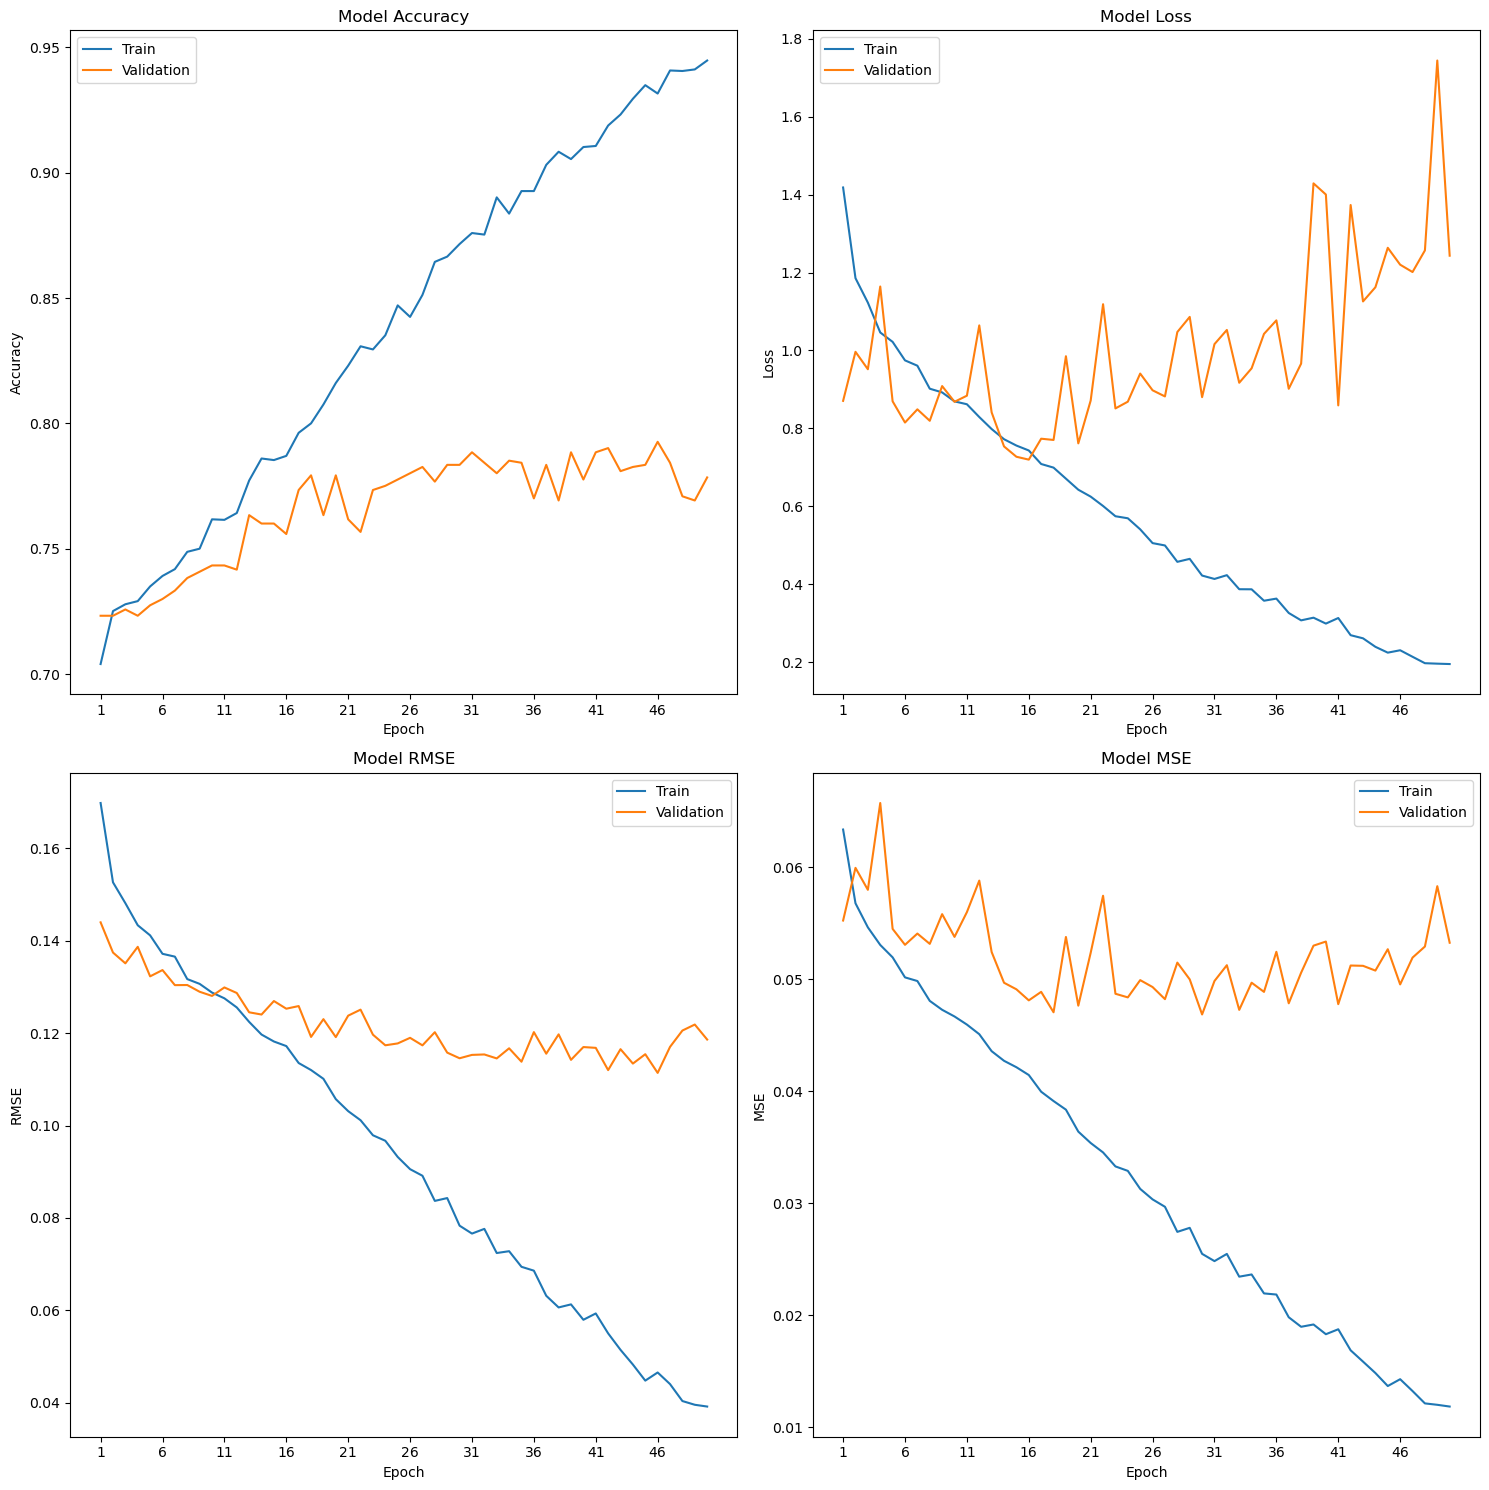

In [111]:
plot_model_history(vgg_history, "VGG16")

GPU detected. Using GPU for predictions.
47/47 [==============================] - 1s 26ms/step


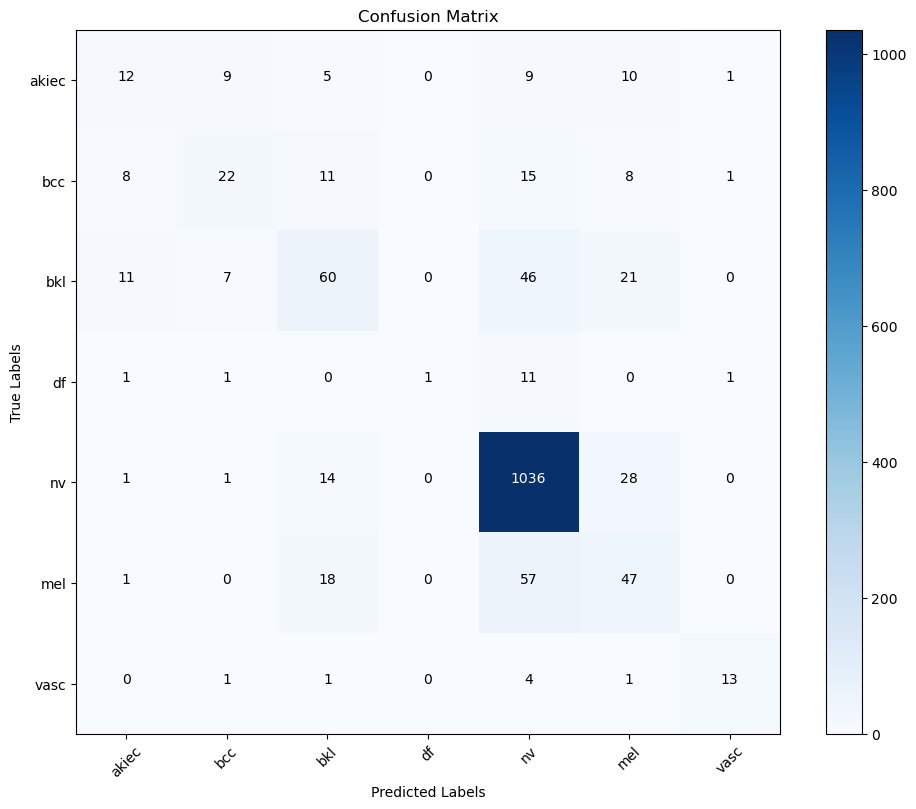

In [112]:
create_confusion_matrix(vgg_model, x_test_normalized, y_test, cm_plot_labels, vgg_model_name)

In [113]:
gen_classification_report(vgg_model, x_test_normalized, y_test, cm_plot_labels)

GPU detected. Using GPU for predictions.
47/47 [==============================] - 1s 25ms/step
              precision    recall  f1-score   support

       akiec       0.35      0.26      0.30        46
         bcc       0.54      0.34      0.42        65
         bkl       0.55      0.41      0.47       145
          df       1.00      0.07      0.12        15
          nv       0.88      0.96      0.92      1080
         mel       0.41      0.38      0.39       123
        vasc       0.81      0.65      0.72        20

    accuracy                           0.80      1494
   macro avg       0.65      0.44      0.48      1494
weighted avg       0.78      0.80      0.78      1494



GPU detected. Using GPU for predictions.
47/47 [==============================] - 1s 25ms/step


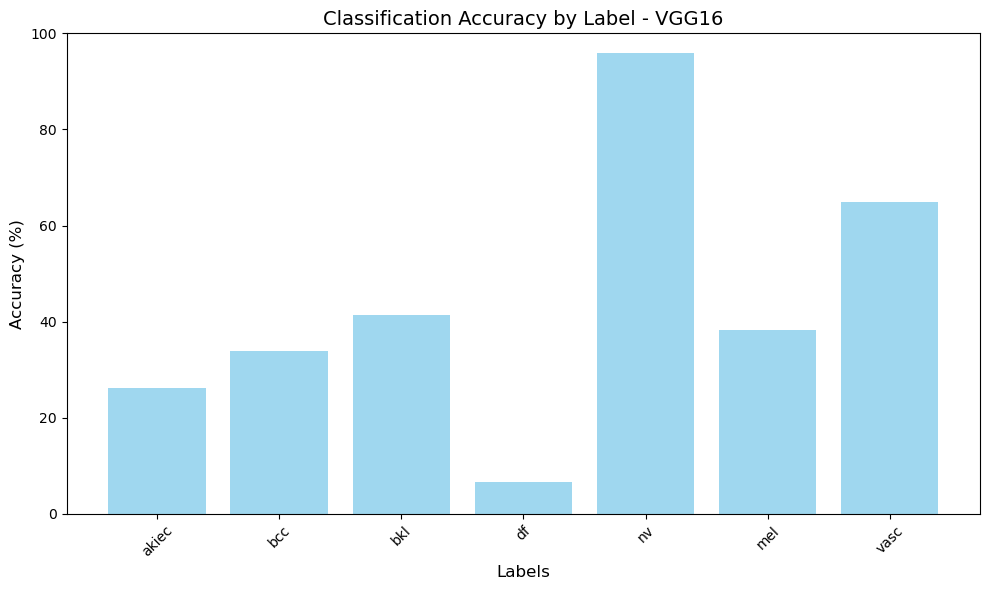

In [114]:
plot_label_classification_acc(vgg_model, x_test_normalized, y_test, cm_plot_labels, vgg_model_name)

# *MobileNetV2*

In [115]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential

base_mobilenet_model = MobileNetV2(include_top=False, weights="imagenet", input_shape=input_shape)

In [116]:
mobilenet_model = Sequential()
mobilenet_model = add_cnn_layers(base_mobilenet_model, mobilenet_model)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 5, 4, 1280)       2257984   
 ional)                                                          
                                                                 
 conv2d_101 (Conv2D)         (None, 5, 4, 64)          737344    
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 2, 2, 64)         0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 2, 2, 64)          0         
                                                                 
 flatten_4 (Flatten)         (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 128)              

In [117]:
mobilenet_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [118]:
from tensorflow.keras.callbacks import CSVLogger, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

mobilenet_time_callback = TimeHistory()
mobilenet_csv_logger = CSVLogger('logs/mobilenet_training.log', separator=',', append=False)
mobilenet_history = mobilenet_model.fit(
    augmented_data.flow(x_train_normalized, y_train, batch_size=batch_size), 
    epochs=epochs,
    verbose=1, 
    class_weight=class_weights,
    validation_data=(x_val_normalized, y_val), 
    steps_per_epoch=steps_per_epoch,
    callbacks=[reduce_lr, mobilenet_time_callback, mobilenet_csv_logger]
)

Epoch 1/50
478/478 [==============================] - 19s 32ms/step - loss: 1.9470 - accuracy: 0.6818 - mse: 0.0751 - mape: 54334436.0000 - rmse: 0.1853 - val_loss: 1.4608 - val_accuracy: 0.7232 - val_mse: 0.0746 - val_mape: 40722604.0000 - val_rmse: 0.1485 - lr: 1.0000e-05
Epoch 2/50
478/478 [==============================] - 15s 30ms/step - loss: 1.4149 - accuracy: 0.7136 - mse: 0.0649 - mape: 49919260.0000 - rmse: 0.1667 - val_loss: 1.3614 - val_accuracy: 0.7232 - val_mse: 0.0721 - val_mape: 40459368.0000 - val_rmse: 0.1459 - lr: 1.0000e-05
Epoch 3/50
478/478 [==============================] - 14s 30ms/step - loss: 1.3458 - accuracy: 0.7192 - mse: 0.0628 - mape: 49495788.0000 - rmse: 0.1635 - val_loss: 1.2344 - val_accuracy: 0.7232 - val_mse: 0.0686 - val_mape: 40713340.0000 - val_rmse: 0.1440 - lr: 1.0000e-05
Epoch 4/50
478/478 [==============================] - 15s 31ms/step - loss: 1.3083 - accuracy: 0.7205 - mse: 0.0615 - mape: 48666976.0000 - rmse: 0.1603 - val_loss: 1.1607 - v

In [119]:
print("\nTotal Time:", sum(mobilenet_time_callback.times), "s\n")


Total Time: 725.7275583744049 s



In [120]:
mobilenet_model.save('Models/mobilenet_model_50epochs.h5')
print("Saved entire model file to disk")

Saved entire model file to disk


In [121]:
mobilenet_model = load_model('Models/mobilenet_model_50epochs.h5', custom_objects=loading_dependencies)
print("Loaded entire model file from disk")

Loaded entire model file from disk


In [122]:
mobilenetv2_log_data = pd.read_csv('logs/mobilenet_training.log', sep=',', engine='python')

In [123]:
mobilenet_model_name = "MobileNetV2"

In [124]:
train_val_accuracy_detailed(mobilenet_model, x_train_normalized, x_val_normalized, y_train, y_val)

Available devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
38/38 [==============================] - 1s 14ms/step - loss: 0.7901 - accuracy: 0.7324 - mse: 0.0526 - mape: 41654728.0000 - rmse: 0.1373
Train Loss: 0.7016971111297607
Train Accuracy: 73.70%
Train RMSE: 0.12845754623413086
Train MSE: 0.04864915832877159
Train MAPE: 39183380.0

Validation Loss: 0.7901106476783752
Validation Accuracy: 73.24%
Validation RMSE: 0.1372656226158142
Validation MSE: 0.05260883644223213
Validation MAPE: 41654728.0



In [125]:
test_accuracy(mobilenet_model, x_test_normalized, y_test)

GPU detected. Using GPU for evaluation.
47/47 [==============================] - 1s 19ms/step - loss: 0.7429 - accuracy: 0.7369 - mse: 0.0502 - mape: 40245952.0000 - rmse: 0.1320

Test Set Accuracy:  73.6947774887085 % 
Test Set Loss: 0.7428654432296753 
Test Set RMSE: 0.13195496797561646 
Test Set MSE: 0.05018468201160431 
Test Set MAPE: 40245952.0


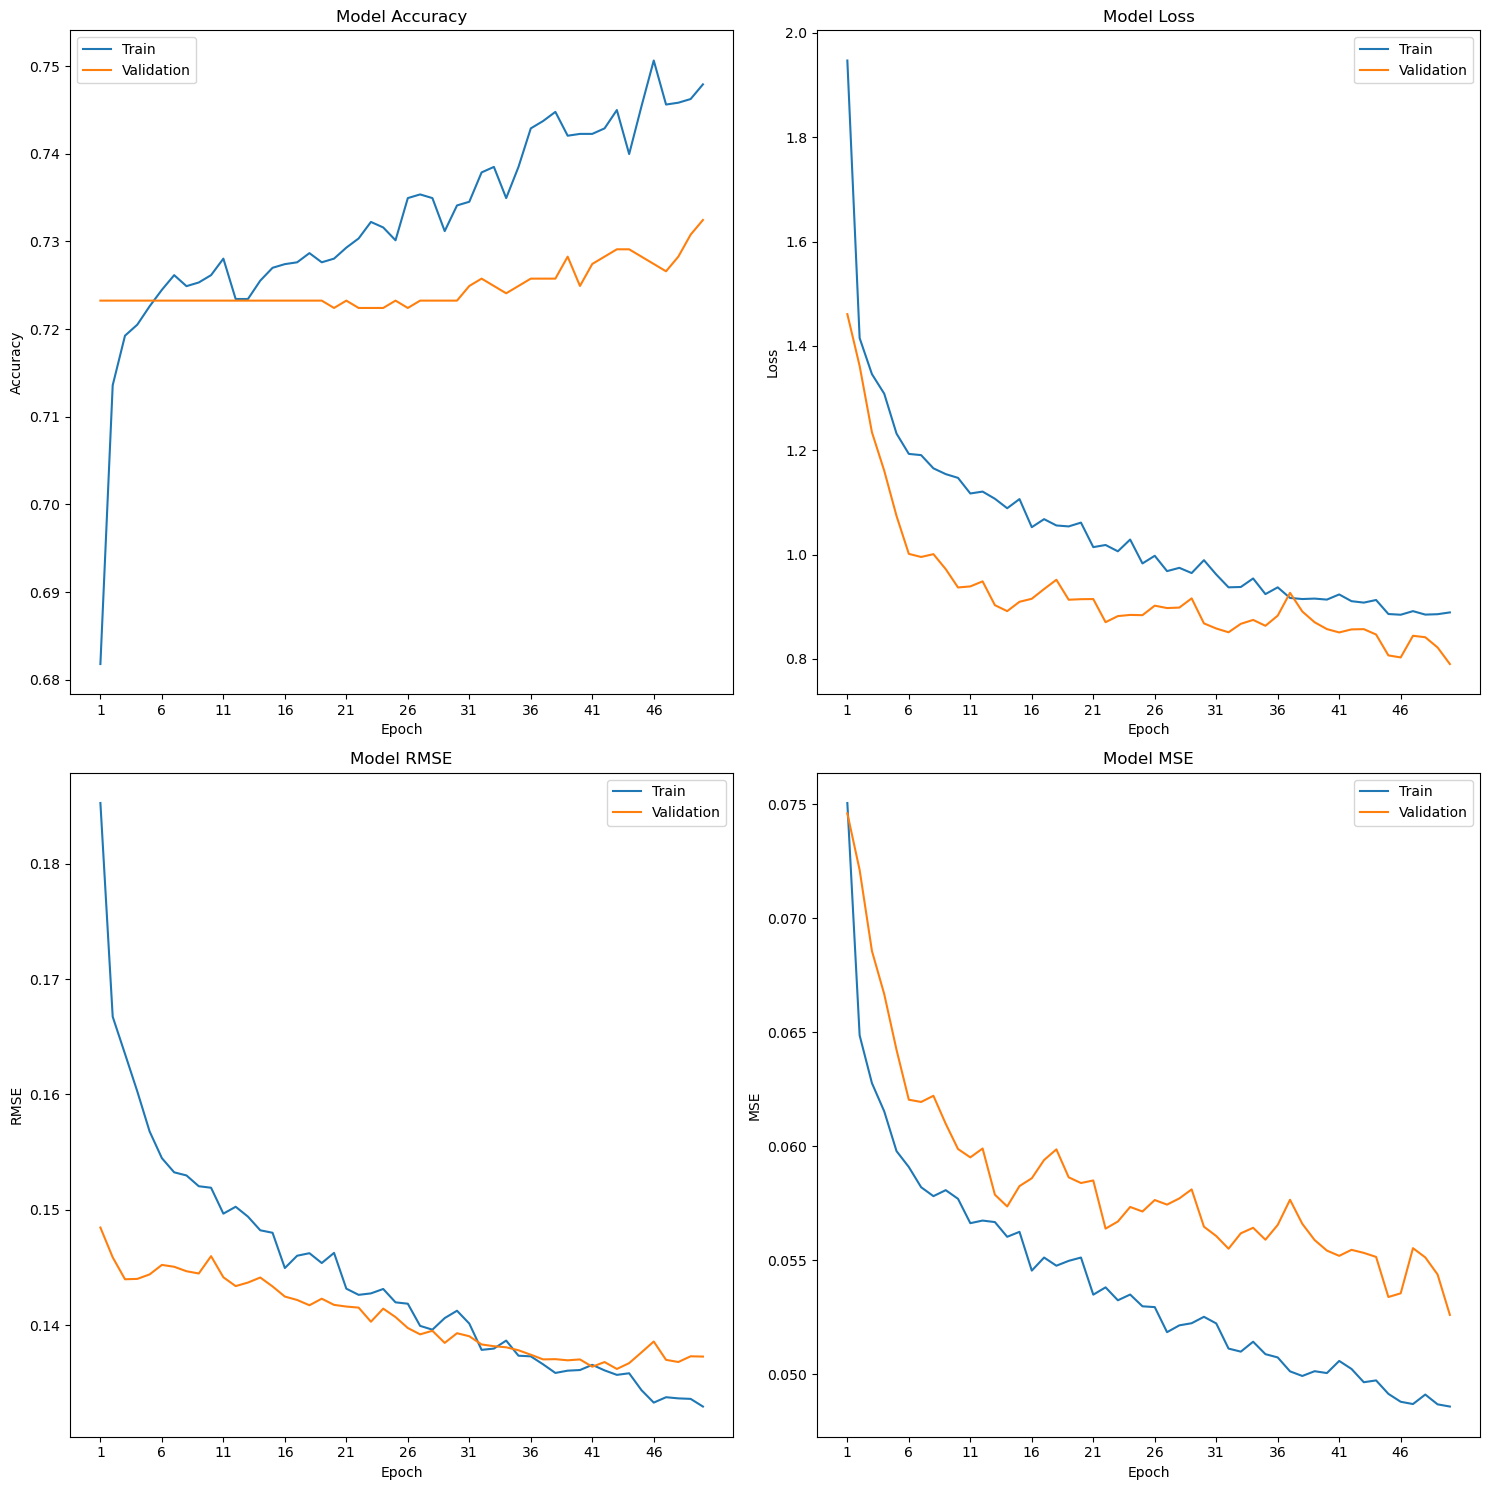

In [126]:
plot_model_history(mobilenet_history, "MobileNetV2")

GPU detected. Using GPU for predictions.
47/47 [==============================] - 1s 12ms/step


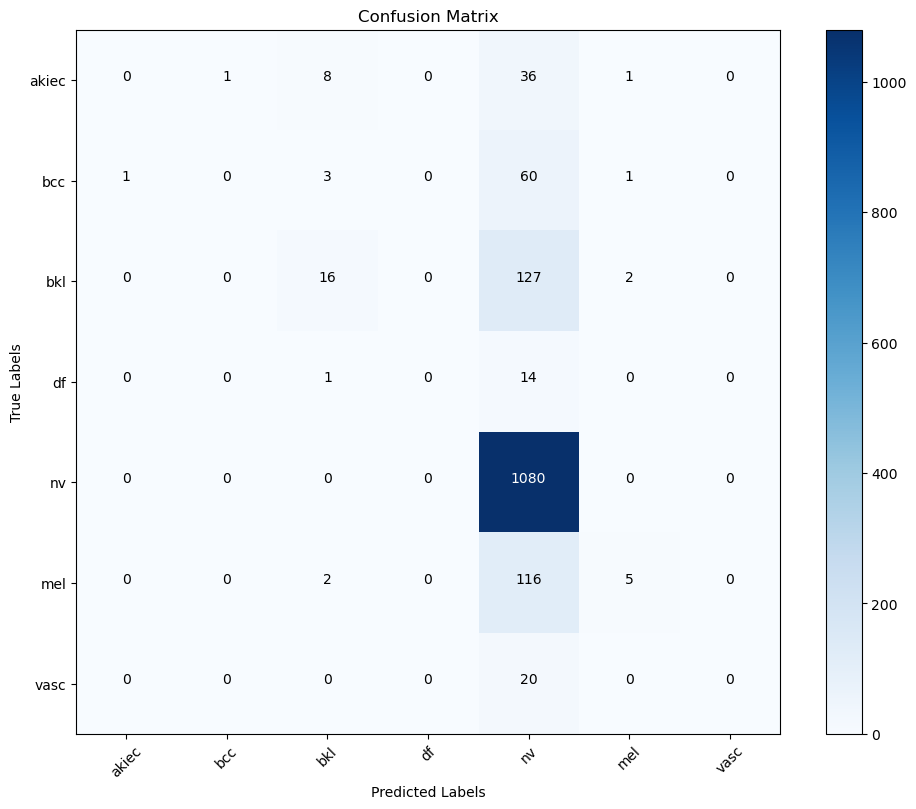

In [127]:
create_confusion_matrix(mobilenet_model, x_test_normalized, y_test, cm_plot_labels, mobilenet_model_name)

In [128]:
gen_classification_report(mobilenet_model, x_test_normalized, y_test, cm_plot_labels)

GPU detected. Using GPU for predictions.
47/47 [==============================] - 1s 12ms/step
              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00        46
         bcc       0.00      0.00      0.00        65
         bkl       0.53      0.11      0.18       145
          df       0.00      0.00      0.00        15
          nv       0.74      1.00      0.85      1080
         mel       0.56      0.04      0.08       123
        vasc       0.00      0.00      0.00        20

    accuracy                           0.74      1494
   macro avg       0.26      0.16      0.16      1494
weighted avg       0.63      0.74      0.64      1494



c:\Users\deepa\anaconda3\envs\dplrn\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\deepa\anaconda3\envs\dplrn\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\deepa\anaconda3\envs\dplrn\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


GPU detected. Using GPU for predictions.
47/47 [==============================] - 1s 12ms/step


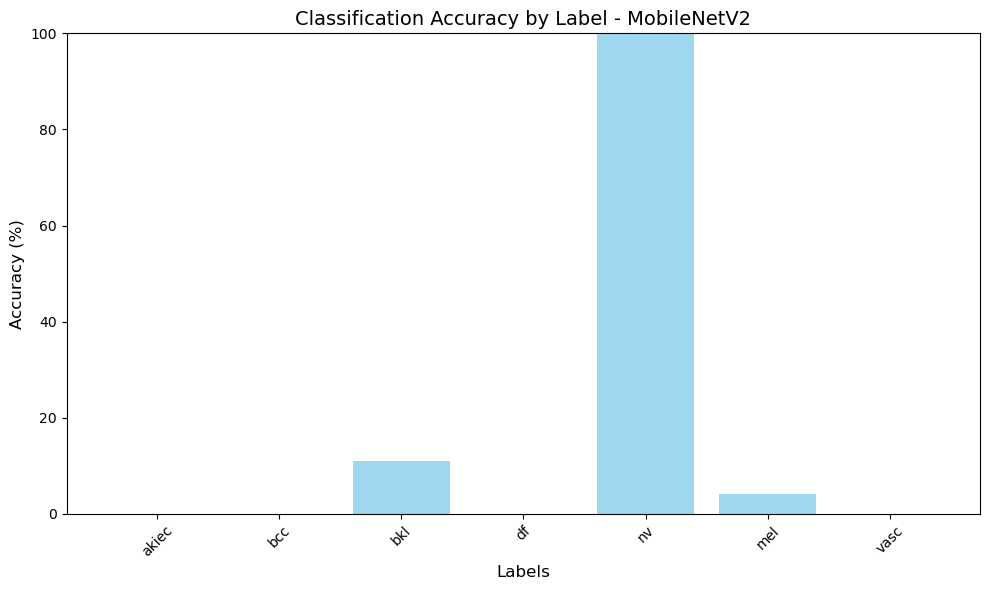

In [129]:
plot_label_classification_acc(mobilenet_model, x_test_normalized, y_test, cm_plot_labels, mobilenet_model_name)

# *InceptionResNetV2*

In [130]:
from tensorflow.keras.applications import InceptionResNetV2

base_inception_model = InceptionResNetV2(include_top=False, weights="imagenet", input_shape=input_shape)


In [131]:
inceptionv2_model = Sequential()
inceptionv2_model = add_cnn_layers(base_inception_model, inceptionv2_model)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 3, 2, 1536)       54336736  
 onal)                                                           
                                                                 
 conv2d_305 (Conv2D)         (None, 3, 2, 64)          884800    
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 1, 1, 64)         0         
 g2D)                                                            
                                                                 
 dropout_8 (Dropout)         (None, 1, 1, 64)          0         
                                                                 
 flatten_5 (Flatten)         (None, 64)                0         
                                                                 
 dense_11 (Dense)            (None, 128)              

In [132]:
inceptionv2_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [133]:
inceptionv2_time_callback = TimeHistory()
inceptionv2_csv_logger = CSVLogger('logs/inceptionv2_training.log', separator=',', append=False)
inceptionv2_history = inceptionv2_model.fit(
    augmented_data.flow(x_train_normalized, y_train, batch_size=batch_size),
    epochs=epochs,
    verbose=1,
    class_weight=class_weights,
    validation_data=(x_val_normalized, y_val),
    steps_per_epoch=steps_per_epoch,
    callbacks=[reduce_lr, inceptionv2_time_callback, inceptionv2_csv_logger]
)

Epoch 1/50
478/478 [==============================] - 72s 118ms/step - loss: 1.4681 - accuracy: 0.7123 - mse: 0.0648 - mape: 53266888.0000 - rmse: 0.1724 - val_loss: 386.2555 - val_accuracy: 0.7232 - val_mse: 0.0576 - val_mape: 46462488.0000 - val_rmse: 0.1495 - lr: 1.0000e-05
Epoch 2/50
478/478 [==============================] - 52s 109ms/step - loss: 1.2519 - accuracy: 0.7203 - mse: 0.0594 - mape: 48853028.0000 - rmse: 0.1570 - val_loss: 269.3209 - val_accuracy: 0.7232 - val_mse: 0.0551 - val_mape: 45912776.0000 - val_rmse: 0.1457 - lr: 1.0000e-05
Epoch 3/50
478/478 [==============================] - 52s 109ms/step - loss: 1.1877 - accuracy: 0.7207 - mse: 0.0575 - mape: 47778276.0000 - rmse: 0.1530 - val_loss: 379.8651 - val_accuracy: 0.7232 - val_mse: 0.0563 - val_mape: 43240516.0000 - val_rmse: 0.1406 - lr: 1.0000e-05
Epoch 4/50
478/478 [==============================] - 52s 108ms/step - loss: 1.1437 - accuracy: 0.7230 - mse: 0.0565 - mape: 46729036.0000 - rmse: 0.1500 - val_loss: 

In [134]:
print("\nTotal Time:", sum(inceptionv2_time_callback.times), "s\n")


Total Time: 2647.0924916267395 s



In [135]:
inceptionv2_model.save('Models/inceptionv2_model_50epochs.h5')
print("Saved entire model file to disk")

Saved entire model file to disk


In [136]:
inceptionv2_model = load_model('Models/inceptionv2_model_50epochs.h5', custom_objects=loading_dependencies)
print("Loaded entire model file from disk")

Loaded entire model file from disk


In [137]:
inceptionv2_log_data = pd.read_csv('logs/inceptionv2_training.log', sep=',', engine='python')

In [138]:
InceptionV2_Model = "InceptionV2"

In [139]:
train_val_accuracy_detailed(inceptionv2_model, x_train_normalized, x_val_normalized, y_train, y_val)

Available devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
38/38 [==============================] - 2s 47ms/step - loss: 45.1620 - accuracy: 0.7751 - mse: 0.0483 - mape: 36180580.0000 - rmse: 0.1218
Train Loss: 9.232356071472168
Train Accuracy: 83.85%
Train RMSE: 0.09011784940958023
Train MSE: 0.03147218003869057
Train MAPE: 27821400.0

Validation Loss: 45.16204833984375
Validation Accuracy: 77.51%
Validation RMSE: 0.12182354182004929
Validation MSE: 0.048317063599824905
Validation MAPE: 36180580.0



In [140]:
# test_accuracy(inceptionv2_model, x_test_normalized, y_test)

import tensorflow as tf

with tf.device('/CPU:0'):
    test_accuracy(inceptionv2_model, x_test_normalized, y_test)

GPU detected. Using GPU for evaluation.
47/47 [==============================] - 3s 53ms/step - loss: 326.5242 - accuracy: 0.7845 - mse: 0.0463 - mape: 34813956.0000 - rmse: 0.1163

Test Set Accuracy:  78.44712138175964 % 
Test Set Loss: 326.52423095703125 
Test Set RMSE: 0.11634788662195206 
Test Set MSE: 0.046258989721536636 
Test Set MAPE: 34813956.0


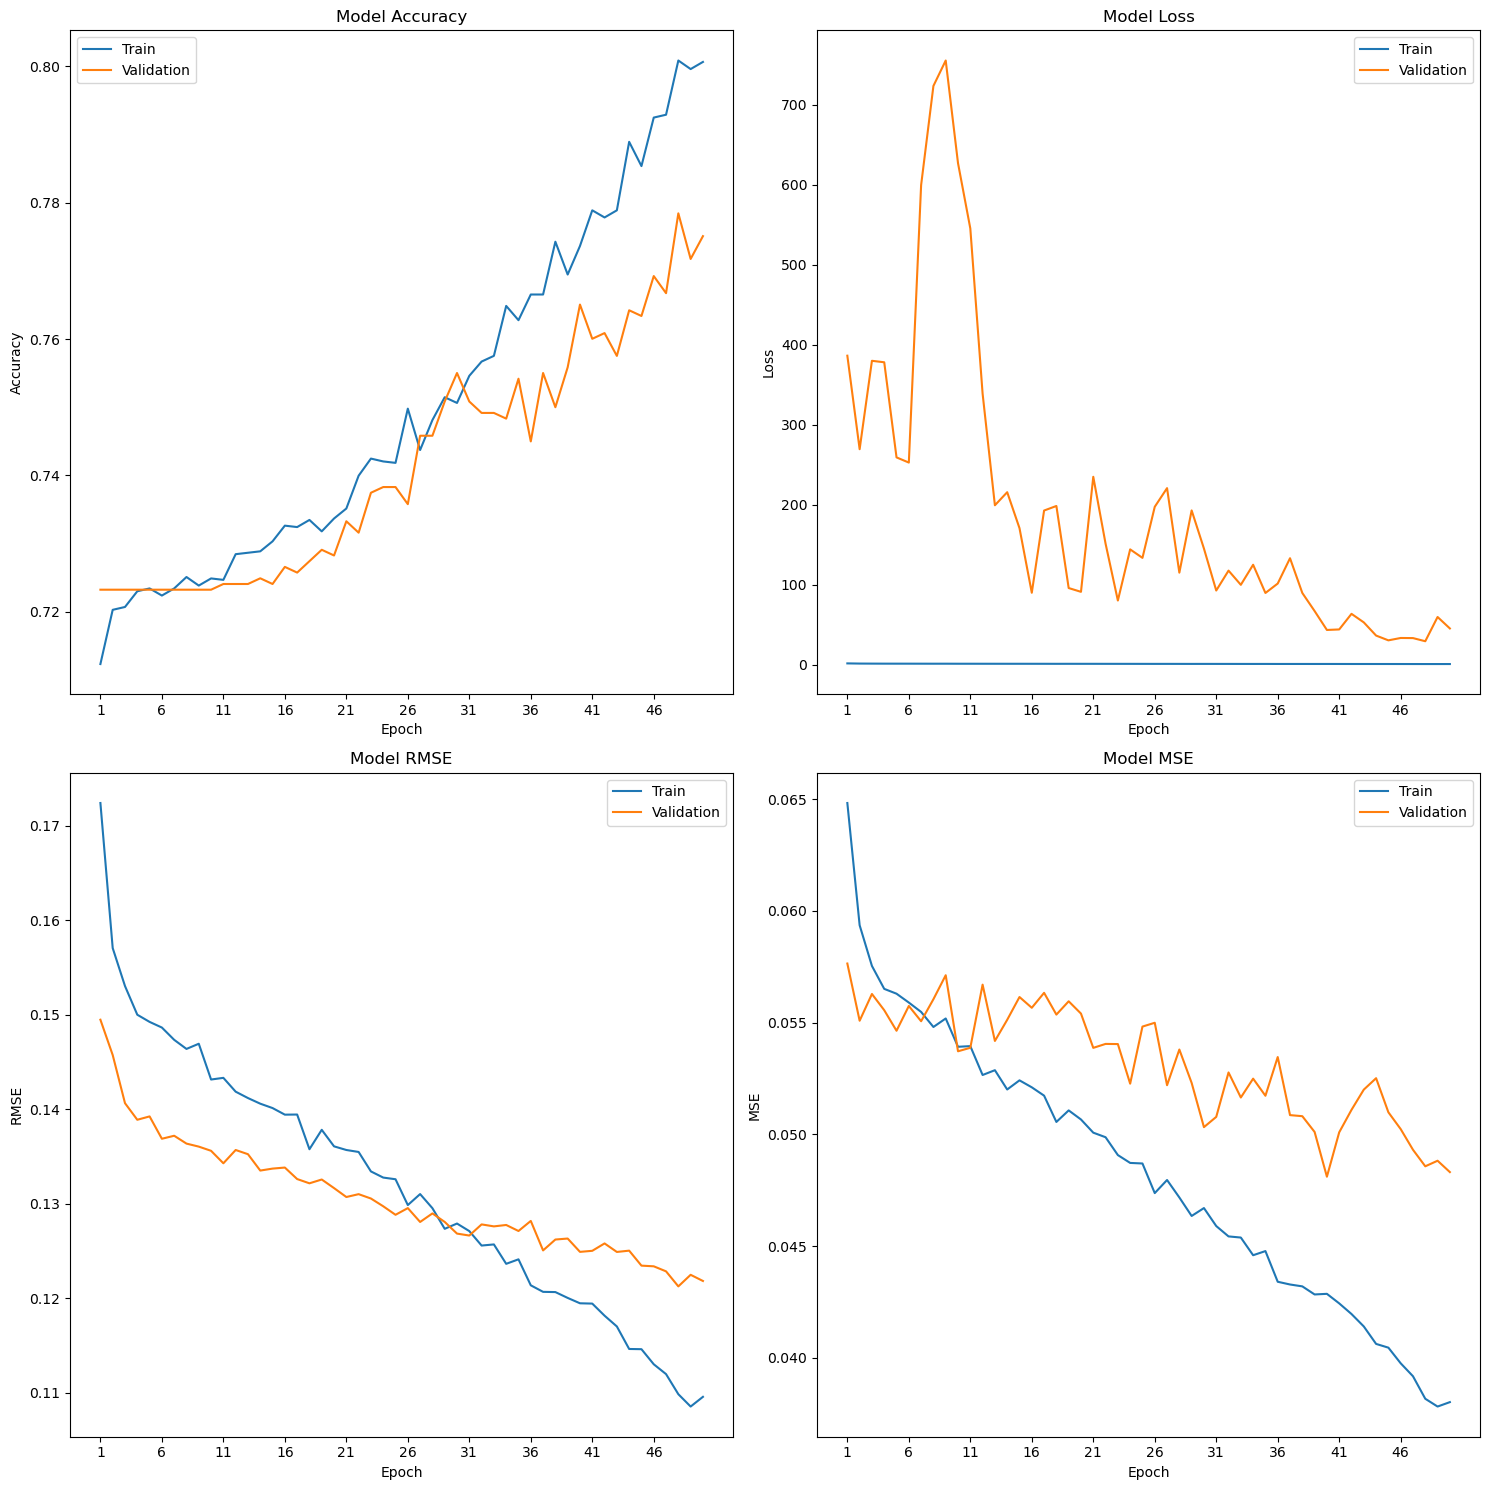

In [141]:
plot_model_history(inceptionv2_history, "InceptionV2")

GPU detected. Using GPU for predictions.
47/47 [==============================] - 5s 46ms/step


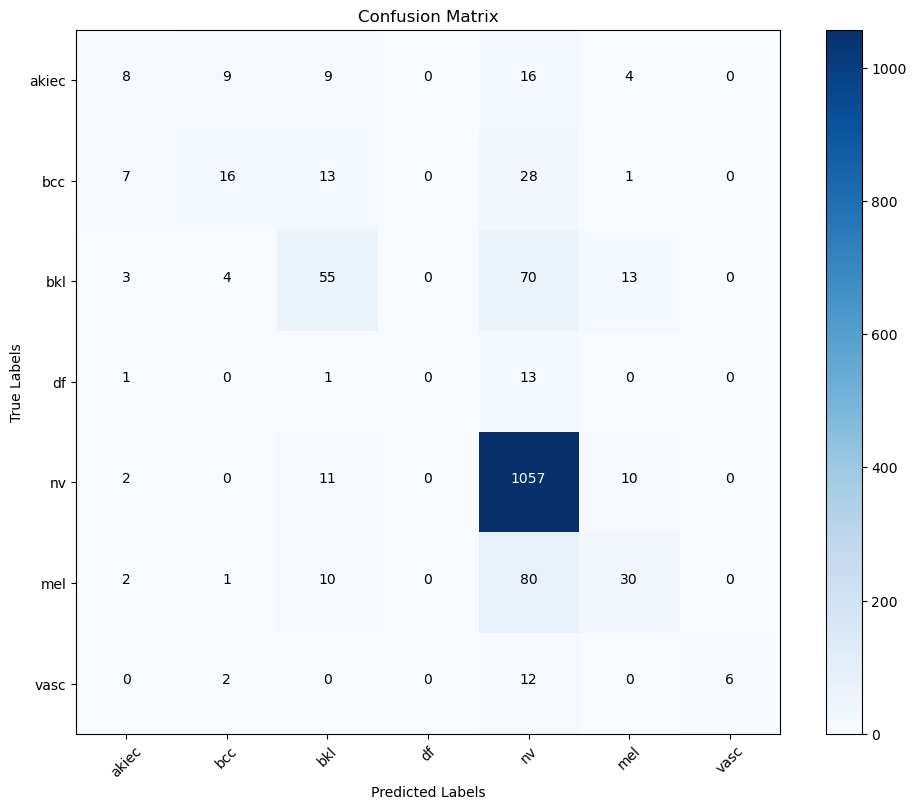

In [142]:
create_confusion_matrix(inceptionv2_model, x_test_normalized, y_test, cm_plot_labels, InceptionV2_Model)

In [143]:
gen_classification_report(inceptionv2_model, x_test_normalized, y_test, cm_plot_labels)

# with tf.device('/CPU:0'):
#     gen_classification_report(inceptionv2_model, x_test_normalized, y_test, cm_plot_labels)

GPU detected. Using GPU for predictions.
47/47 [==============================] - 2s 44ms/step
              precision    recall  f1-score   support

       akiec       0.35      0.17      0.23        46
         bcc       0.50      0.25      0.33        65
         bkl       0.56      0.38      0.45       145
          df       0.00      0.00      0.00        15
          nv       0.83      0.98      0.90      1080
         mel       0.52      0.24      0.33       123
        vasc       1.00      0.30      0.46        20

    accuracy                           0.78      1494
   macro avg       0.54      0.33      0.39      1494
weighted avg       0.74      0.78      0.75      1494



c:\Users\deepa\anaconda3\envs\dplrn\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\deepa\anaconda3\envs\dplrn\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\deepa\anaconda3\envs\dplrn\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


GPU detected. Using GPU for predictions.
Error: Graph execution error:

SameWorkerRecvDone unable to allocate output tensor. Key: /job:localhost/replica:0/task:0/device:CPU:0;a446cc152a75d7ad;/job:localhost/replica:0/task:0/device:GPU:0;edge_905_IteratorGetNext;0:0
	 [[{{node IteratorGetNext/_2}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_predict_function_1339168]. Switching to CPU.
47/47 [==============================] - 27s 557ms/step


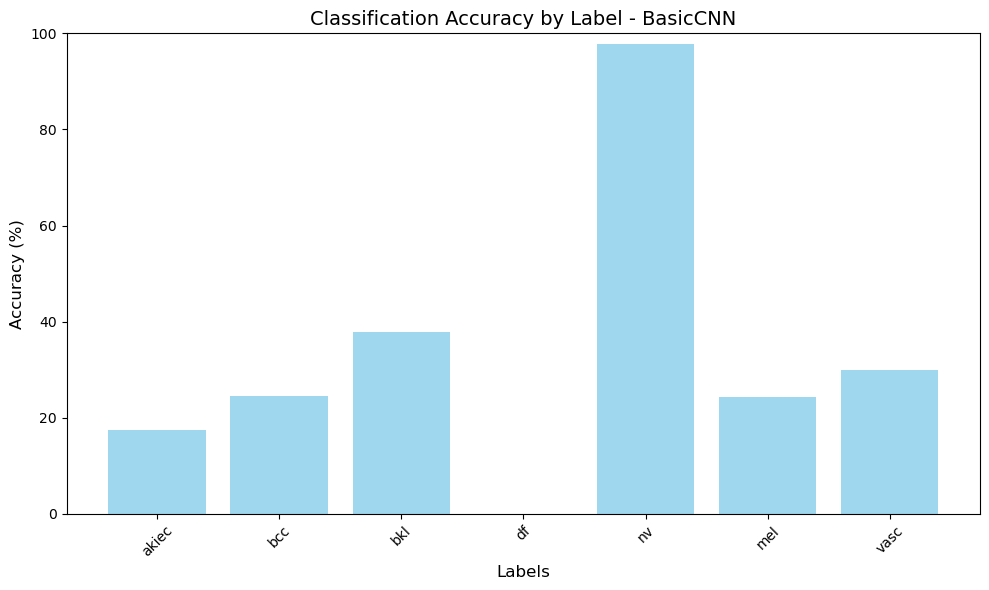

In [144]:
plot_label_classification_acc(inceptionv2_model, x_test_normalized, y_test, cm_plot_labels, model_name)
# with tf.device('/CPU:0'):
#     plot_label_classification_acc(inceptionv2_model, x_test_normalized, y_test, cm_plot_labels, InceptionV2_Model)